# Super Fast and Accurate 3D Object Detection
Predicting Cars in Lidar data using SFA3D

Github Link to Original Code: https://github.com/maudzung/SFA3D

# Configuration

## KITT Data Configuration

In [2]:
import math

import numpy as np

# Car and Van ==> Car class
# Pedestrian and Person_Sitting ==> Pedestrian Class
CLASS_NAME_TO_ID = {
    'Pedestrian': 0,
    'Car': 1,
    'Cyclist': 2,
    'Van': 1,
    'Truck': -3,
    'Person_sitting': 0,
    'Tram': -99,
    'Misc': -99,
    
}

colors = [[0, 255, 255], [0, 0, 255], [255, 0, 0], [255, 120, 0],
          [255, 120, 120], [0, 120, 0], [120, 255, 255], [120, 0, 255]]

#####################################################################################
boundary = {
    "minX": 0,
    "maxX": 50,
    "minY": -25,
    "maxY": 25,
    "minZ": -2.73,
    "maxZ": 1.27
}

bound_size_x = boundary['maxX'] - boundary['minX']
bound_size_y = boundary['maxY'] - boundary['minY']
bound_size_z = boundary['maxZ'] - boundary['minZ']

boundary_back = {
    "minX": -50,
    "maxX": 0,
    "minY": -25,
    "maxY": 25,
    "minZ": -2.73,
    "maxZ": 1.27
}

BEV_WIDTH = 608  # across y axis -25m ~ 25m
BEV_HEIGHT = 608  # across x axis 0m ~ 50m
DISCRETIZATION = (boundary["maxX"] - boundary["minX"]) / BEV_HEIGHT

# maximum number of points per voxel
T = 35

# voxel size
vd = 0.1  # z
vh = 0.05  # y
vw = 0.05  # x

# voxel grid
W = math.ceil(bound_size_x / vw)
H = math.ceil(bound_size_y / vh)
D = math.ceil(bound_size_z / vd)

# Following parameters are calculated as an average from KITTI dataset for simplicity
#####################################################################################
Tr_velo_to_cam = np.array([
    [7.49916597e-03, -9.99971248e-01, -8.65110297e-04, -6.71807577e-03],
    [1.18652889e-02, 9.54520517e-04, -9.99910318e-01, -7.33152811e-02],
    [9.99882833e-01, 7.49141178e-03, 1.18719929e-02, -2.78557062e-01],
    [0, 0, 0, 1]
])

# cal mean from train set
R0 = np.array([
    [0.99992475, 0.00975976, -0.00734152, 0],
    [-0.0097913, 0.99994262, -0.00430371, 0],
    [0.00729911, 0.0043753, 0.99996319, 0],
    [0, 0, 0, 1]
])

P2 = np.array([[719.787081, 0., 608.463003, 44.9538775],
               [0., 719.787081, 174.545111, 0.1066855],
               [0., 0., 1., 3.0106472e-03],
               [0., 0., 0., 0]
               ])

R0_inv = np.linalg.inv(R0)
Tr_velo_to_cam_inv = np.linalg.inv(Tr_velo_to_cam)
P2_inv = np.linalg.pinv(P2)
#####################################################################################

## Training Configurations

In [3]:
import os

import torch
from easydict import EasyDict as edict

def parse_configs():
    config_dict = {}
    config_dict['seed'] = 2020
    config_dict['saved_fn'] = 'fpn_resnet_18'
    config_dict['root_dir'] = './'
    
    ####################################################################
    ##############     Model configs            ########################
    ####################################################################
    config_dict['arch'] = 'fpn_resnet_18'
    config_dict['pretrained_path'] = None
    ####################################################################
    ##############     Dataloader and Running configs            #######
    ####################################################################
    config_dict['hflip_prob'] = 0.5
    config_dict['no_val'] = False
    config_dict['num_samples'] = None
    config_dict['num_workers'] = 4
    config_dict['batch_size'] = 16
    config_dict['print_freq'] = 50
    config_dict['tensorboard_freq'] = 50
    config_dict['checkpoint_freq'] = 1
    ####################################################################
    ##############     Training strategy            ####################
    ####################################################################
    config_dict['start_epoch'] = 1
    config_dict['num_epochs'] = 10
    config_dict['lr_type'] = 'cosin'
    config_dict['lr'] = 0.001
    config_dict['minimum_lr'] = 1e-7
    config_dict['momentum'] = 0.949
    config_dict['weight_decay'] = 0
    config_dict['optimizer_type'] = 'adam'
    config_dict['steps'] = [150, 180]

    ####################################################################
    ##############     Loss weight            ##########################
    ####################################################################

    ####################################################################
    ##############     Distributed Data Parallel            ############
    ####################################################################
    config_dict['world_size'] = -1
    config_dict['rank'] = -1
    config_dict['dist_url'] = 'tcp://127.0.0.1:29500'
    config_dict['gpu_idx'] = 0
    config_dict['no_cuda'] = False
    config_dict['multiprocessing_distributed'] = False
    ####################################################################
    ##############     Evaluation configurations     ###################
    ####################################################################
    config_dict['evaluate'] = False
    config_dict['resume_path'] = None
    config_dict['K'] = 50

    configs = edict(config_dict)

    ####################################################################
    ############## Hardware configurations #############################
    ####################################################################
    configs.device = torch.device('cpu' if configs.no_cuda else 'cuda')
    configs.ngpus_per_node = torch.cuda.device_count()

    configs.pin_memory = True
    configs.input_size = (608, 608)
    configs.hm_size = (152, 152)
    configs.down_ratio = 4
    configs.max_objects = 50

    configs.imagenet_pretrained = True
    configs.head_conv = 64
    configs.num_classes = 3
    configs.num_center_offset = 2
    configs.num_z = 1
    configs.num_dim = 3
    configs.num_direction = 2  # sin, cos

    configs.heads = {
        'hm_cen': configs.num_classes,
        'cen_offset': configs.num_center_offset,
        'direction': configs.num_direction,
        'z_coor': configs.num_z,
        'dim': configs.num_dim
    }

    configs.num_input_features = 4

    ####################################################################
    ############## Dataset, logs, Checkpoints dir ######################
    ####################################################################
    configs.dataset_dir = '../input/kitti-3d-object-detection-dataset/'
    configs.checkpoints_dir = os.path.join(configs.root_dir, 'checkpoints', configs.saved_fn)
    configs.logs_dir = os.path.join(configs.root_dir, 'logs', configs.saved_fn)

    if not os.path.isdir(configs.checkpoints_dir):
        os.makedirs(configs.checkpoints_dir)
    if not os.path.isdir(configs.logs_dir):
        os.makedirs(configs.logs_dir)

    return configs

# Data Processing


## Transformation Functions

In [4]:
import os
import sys
import math

import numpy as np
import torch

def angle_in_limit(angle):
    # To limit the angle in -pi/2 - pi/2
    limit_degree = 5
    while angle >= np.pi / 2:
        angle -= np.pi
    while angle < -np.pi / 2:
        angle += np.pi
    if abs(angle + np.pi / 2) < limit_degree / 180 * np.pi:
        angle = np.pi / 2
    return angle


def camera_to_lidar(x, y, z, V2C=None, R0=None, P2=None):
    p = np.array([x, y, z, 1])
    if V2C is None or R0 is None:
        p = np.matmul(R0_inv, p)
        p = np.matmul(Tr_velo_to_cam_inv, p)
    else:
        R0_i = np.zeros((4, 4))
        R0_i[:3, :3] = R0
        R0_i[3, 3] = 1
        p = np.matmul(np.linalg.inv(R0_i), p)
        p = np.matmul(inverse_rigid_trans(V2C), p)
    p = p[0:3]
    return tuple(p)


def lidar_to_camera(x, y, z, V2C=None, R0=None, P2=None):
    p = np.array([x, y, z, 1])
    if V2C is None or R0 is None:
        p = np.matmul(Tr_velo_to_cam, p)
        p = np.matmul(R0, p)
    else:
        p = np.matmul(V2C, p)
        p = np.matmul(R0, p)
    p = p[0:3]
    return tuple(p)


def camera_to_lidar_point(points):
    # (N, 3) -> (N, 3)
    N = points.shape[0]
    points = np.hstack([points, np.ones((N, 1))]).T  # (N,4) -> (4,N)

    points = np.matmul(R0_inv, points)
    points = np.matmul(Tr_velo_to_cam_inv, points).T  # (4, N) -> (N, 4)
    points = points[:, 0:3]
    return points.reshape(-1, 3)


def lidar_to_camera_point(points, V2C = None):
    # (N, 3) -> (N, 3)
    N = points.shape[0]
    points = np.hstack([points, np.ones((N, 1))]).T

    if V2C is None or R0 is None:
        points = np.matmul(Tr_velo_to_cam, points)
        points = np.matmul(R0, points).T
    else:
        points = np.matmul(V2C, points)
        points = np.matmul(R0, points).T
    points = points[:, 0:3]
    return points.reshape(-1, 3)


def camera_to_lidar_box(boxes, V2C=None, R0=None, P2=None):
    # (N, 7) -> (N, 7) x,y,z,h,w,l,r
    ret = []
    for box in boxes:
        x, y, z, h, w, l, ry = box
        (x, y, z), h, w, l, rz = camera_to_lidar(x, y, z, V2C=V2C, R0=R0, P2=P2), h, w, l, -ry - np.pi / 2
        # rz = angle_in_limit(rz)
        ret.append([x, y, z, h, w, l, rz])
    return np.array(ret).reshape(-1, 7)


def lidar_to_camera_box(boxes, V2C=None, R0=None, P2=None):
    # (N, 7) -> (N, 7) x,y,z,h,w,l,r
    ret = []
    for box in boxes:
        x, y, z, h, w, l, rz = box
        (x, y, z), h, w, l, ry = lidar_to_camera(x, y, z, V2C=V2C, R0=R0, P2=P2), h, w, l, -rz - np.pi / 2
        # ry = angle_in_limit(ry)
        ret.append([x, y, z, h, w, l, ry])
    return np.array(ret).reshape(-1, 7)


def center_to_corner_box2d(boxes_center, coordinate='lidar'):
    # (N, 5) -> (N, 4, 2)
    N = boxes_center.shape[0]
    boxes3d_center = np.zeros((N, 7))
    boxes3d_center[:, [0, 1, 4, 5, 6]] = boxes_center
    boxes3d_corner = center_to_corner_box3d(boxes3d_center, coordinate=coordinate)

    return boxes3d_corner[:, 0:4, 0:2]


def center_to_corner_box3d(boxes_center, coordinate='lidar'):
    # (N, 7) -> (N, 8, 3)
    N = boxes_center.shape[0]
    ret = np.zeros((N, 8, 3), dtype=np.float32)

    if coordinate == 'camera':
        boxes_center = camera_to_lidar_box(boxes_center)

    for i in range(N):
        box = boxes_center[i]
        translation = box[0:3]
        size = box[3:6]
        rotation = [0, 0, box[-1]]

        h, w, l = size[0], size[1], size[2]
        trackletBox = np.array([  # in velodyne coordinates around zero point and without orientation yet
            [-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2], \
            [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2], \
            [0, 0, 0, 0, h, h, h, h]])

        # re-create 3D bounding box in velodyne coordinate system
        yaw = rotation[2]
        rotMat = np.array([
            [np.cos(yaw), -np.sin(yaw), 0.0],
            [np.sin(yaw), np.cos(yaw), 0.0],
            [0.0, 0.0, 1.0]])
        cornerPosInVelo = np.dot(rotMat, trackletBox) + np.tile(translation, (8, 1)).T
        box3d = cornerPosInVelo.transpose()
        ret[i] = box3d

    if coordinate == 'camera':
        for idx in range(len(ret)):
            ret[idx] = lidar_to_camera_point(ret[idx])

    return ret


CORNER2CENTER_AVG = True


def corner_to_center_box3d(boxes_corner, coordinate='camera'):
    # (N, 8, 3) -> (N, 7) x,y,z,h,w,l,ry/z
    if coordinate == 'lidar':
        for idx in range(len(boxes_corner)):
            boxes_corner[idx] = lidar_to_camera_point(boxes_corner[idx])

    ret = []
    for roi in boxes_corner:
        if CORNER2CENTER_AVG:  # average version
            roi = np.array(roi)
            h = abs(np.sum(roi[:4, 1] - roi[4:, 1]) / 4)
            w = np.sum(
                np.sqrt(np.sum((roi[0, [0, 2]] - roi[3, [0, 2]]) ** 2)) +
                np.sqrt(np.sum((roi[1, [0, 2]] - roi[2, [0, 2]]) ** 2)) +
                np.sqrt(np.sum((roi[4, [0, 2]] - roi[7, [0, 2]]) ** 2)) +
                np.sqrt(np.sum((roi[5, [0, 2]] - roi[6, [0, 2]]) ** 2))
            ) / 4
            l = np.sum(
                np.sqrt(np.sum((roi[0, [0, 2]] - roi[1, [0, 2]]) ** 2)) +
                np.sqrt(np.sum((roi[2, [0, 2]] - roi[3, [0, 2]]) ** 2)) +
                np.sqrt(np.sum((roi[4, [0, 2]] - roi[5, [0, 2]]) ** 2)) +
                np.sqrt(np.sum((roi[6, [0, 2]] - roi[7, [0, 2]]) ** 2))
            ) / 4
            x = np.sum(roi[:, 0], axis=0) / 8
            y = np.sum(roi[0:4, 1], axis=0) / 4
            z = np.sum(roi[:, 2], axis=0) / 8
            ry = np.sum(
                math.atan2(roi[2, 0] - roi[1, 0], roi[2, 2] - roi[1, 2]) +
                math.atan2(roi[6, 0] - roi[5, 0], roi[6, 2] - roi[5, 2]) +
                math.atan2(roi[3, 0] - roi[0, 0], roi[3, 2] - roi[0, 2]) +
                math.atan2(roi[7, 0] - roi[4, 0], roi[7, 2] - roi[4, 2]) +
                math.atan2(roi[0, 2] - roi[1, 2], roi[1, 0] - roi[0, 0]) +
                math.atan2(roi[4, 2] - roi[5, 2], roi[5, 0] - roi[4, 0]) +
                math.atan2(roi[3, 2] - roi[2, 2], roi[2, 0] - roi[3, 0]) +
                math.atan2(roi[7, 2] - roi[6, 2], roi[6, 0] - roi[7, 0])
            ) / 8
            if w > l:
                w, l = l, w
                ry = ry - np.pi / 2
            elif l > w:
                l, w = w, l
                ry = ry - np.pi / 2
            ret.append([x, y, z, h, w, l, ry])

        else:  # max version
            h = max(abs(roi[:4, 1] - roi[4:, 1]))
            w = np.max(
                np.sqrt(np.sum((roi[0, [0, 2]] - roi[3, [0, 2]]) ** 2)) +
                np.sqrt(np.sum((roi[1, [0, 2]] - roi[2, [0, 2]]) ** 2)) +
                np.sqrt(np.sum((roi[4, [0, 2]] - roi[7, [0, 2]]) ** 2)) +
                np.sqrt(np.sum((roi[5, [0, 2]] - roi[6, [0, 2]]) ** 2))
            )
            l = np.max(
                np.sqrt(np.sum((roi[0, [0, 2]] - roi[1, [0, 2]]) ** 2)) +
                np.sqrt(np.sum((roi[2, [0, 2]] - roi[3, [0, 2]]) ** 2)) +
                np.sqrt(np.sum((roi[4, [0, 2]] - roi[5, [0, 2]]) ** 2)) +
                np.sqrt(np.sum((roi[6, [0, 2]] - roi[7, [0, 2]]) ** 2))
            )
            x = np.sum(roi[:, 0], axis=0) / 8
            y = np.sum(roi[0:4, 1], axis=0) / 4
            z = np.sum(roi[:, 2], axis=0) / 8
            ry = np.sum(
                math.atan2(roi[2, 0] - roi[1, 0], roi[2, 2] - roi[1, 2]) +
                math.atan2(roi[6, 0] - roi[5, 0], roi[6, 2] - roi[5, 2]) +
                math.atan2(roi[3, 0] - roi[0, 0], roi[3, 2] - roi[0, 2]) +
                math.atan2(roi[7, 0] - roi[4, 0], roi[7, 2] - roi[4, 2]) +
                math.atan2(roi[0, 2] - roi[1, 2], roi[1, 0] - roi[0, 0]) +
                math.atan2(roi[4, 2] - roi[5, 2], roi[5, 0] - roi[4, 0]) +
                math.atan2(roi[3, 2] - roi[2, 2], roi[2, 0] - roi[3, 0]) +
                math.atan2(roi[7, 2] - roi[6, 2], roi[6, 0] - roi[7, 0])
            ) / 8
            if w > l:
                w, l = l, w
                ry = angle_in_limit(ry + np.pi / 2)
            ret.append([x, y, z, h, w, l, ry])

    if coordinate == 'lidar':
        ret = camera_to_lidar_box(np.array(ret))

    return np.array(ret)


def point_transform(points, tx, ty, tz, rx=0, ry=0, rz=0):
    # Input:
    #   points: (N, 3)
    #   rx/y/z: in radians
    # Output:
    #   points: (N, 3)
    N = points.shape[0]
    points = np.hstack([points, np.ones((N, 1))])

    mat1 = np.eye(4)
    mat1[3, 0:3] = tx, ty, tz
    points = np.matmul(points, mat1)

    if rx != 0:
        mat = np.zeros((4, 4))
        mat[0, 0] = 1
        mat[3, 3] = 1
        mat[1, 1] = np.cos(rx)
        mat[1, 2] = -np.sin(rx)
        mat[2, 1] = np.sin(rx)
        mat[2, 2] = np.cos(rx)
        points = np.matmul(points, mat)

    if ry != 0:
        mat = np.zeros((4, 4))
        mat[1, 1] = 1
        mat[3, 3] = 1
        mat[0, 0] = np.cos(ry)
        mat[0, 2] = np.sin(ry)
        mat[2, 0] = -np.sin(ry)
        mat[2, 2] = np.cos(ry)
        points = np.matmul(points, mat)

    if rz != 0:
        mat = np.zeros((4, 4))
        mat[2, 2] = 1
        mat[3, 3] = 1
        mat[0, 0] = np.cos(rz)
        mat[0, 1] = -np.sin(rz)
        mat[1, 0] = np.sin(rz)
        mat[1, 1] = np.cos(rz)
        points = np.matmul(points, mat)

    return points[:, 0:3]


def box_transform(boxes, tx, ty, tz, r=0, coordinate='lidar'):
    # Input:
    #   boxes: (N, 7) x y z h w l rz/y
    # Output:
    #   boxes: (N, 7) x y z h w l rz/y
    boxes_corner = center_to_corner_box3d(boxes, coordinate=coordinate)  # (N, 8, 3)
    for idx in range(len(boxes_corner)):
        if coordinate == 'lidar':
            boxes_corner[idx] = point_transform(boxes_corner[idx], tx, ty, tz, rz=r)
        else:
            boxes_corner[idx] = point_transform(boxes_corner[idx], tx, ty, tz, ry=r)

    return corner_to_center_box3d(boxes_corner, coordinate=coordinate)


def inverse_rigid_trans(Tr):
    ''' Inverse a rigid body transform matrix (3x4 as [R|t])
        [R'|-R't; 0|1]
    '''
    inv_Tr = np.zeros_like(Tr)  # 3x4
    inv_Tr[0:3, 0:3] = np.transpose(Tr[0:3, 0:3])
    inv_Tr[0:3, 3] = np.dot(-np.transpose(Tr[0:3, 0:3]), Tr[0:3, 3])
    return inv_Tr


class Compose(object):
    def __init__(self, transforms, p=1.0):
        self.transforms = transforms
        self.p = p

    def __call__(self, lidar, labels):
        if np.random.random() <= self.p:
            for t in self.transforms:
                lidar, labels = t(lidar, labels)
        return lidar, labels


class OneOf(object):
    def __init__(self, transforms, p=1.0):
        self.transforms = transforms
        self.p = p

    def __call__(self, lidar, labels):
        if np.random.random() <= self.p:
            choice = np.random.randint(low=0, high=len(self.transforms))
            lidar, labels = self.transforms[choice](lidar, labels)

        return lidar, labels


class Random_Rotation(object):
    def __init__(self, limit_angle=np.pi / 4, p=0.5):
        self.limit_angle = limit_angle
        self.p = p

    def __call__(self, lidar, labels):
        """
        :param labels: # (N', 7) x, y, z, h, w, l, r
        :return:
        """
        if np.random.random() <= self.p:
            angle = np.random.uniform(-self.limit_angle, self.limit_angle)
            lidar[:, 0:3] = point_transform(lidar[:, 0:3], 0, 0, 0, rz=angle)
            labels = box_transform(labels, 0, 0, 0, r=angle, coordinate='lidar')

        return lidar, labels


class Random_Scaling(object):
    def __init__(self, scaling_range=(0.95, 1.05), p=0.5):
        self.scaling_range = scaling_range
        self.p = p

    def __call__(self, lidar, labels):
        """
        :param labels: # (N', 7) x, y, z, h, w, l, r
        :return:
        """
        if np.random.random() <= self.p:
            factor = np.random.uniform(self.scaling_range[0], self.scaling_range[0])
            lidar[:, 0:3] = lidar[:, 0:3] * factor
            labels[:, 0:6] = labels[:, 0:6] * factor

        return lidar, labels


class Cutout(object):
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
        Refer from: https://github.com/uoguelph-mlrg/Cutout/blob/master/util/cutout.py
    """

    def __init__(self, n_holes, ratio, fill_value=0., p=1.0):
        self.n_holes = n_holes
        self.ratio = ratio
        assert 0. <= fill_value <= 1., "the fill value is in a range of 0 to 1"
        self.fill_value = fill_value
        self.p = p

    def __call__(self, img, targets):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        if np.random.random() <= self.p:
            h = img.size(1)
            w = img.size(2)

            h_cutout = int(self.ratio * h)
            w_cutout = int(self.ratio * w)

            for n in range(self.n_holes):
                y = np.random.randint(h)
                x = np.random.randint(w)

                y1 = np.clip(y - h_cutout // 2, 0, h)
                y2 = np.clip(y + h_cutout // 2, 0, h)
                x1 = np.clip(x - w_cutout // 2, 0, w)
                x2 = np.clip(x + w_cutout // 2, 0, w)

                img[:, y1: y2, x1: x2] = self.fill_value  # Zero out the selected area
                # Remove targets that are in the selected area
                keep_target = []
                for target_idx, target in enumerate(targets):
                    _, _, target_x, target_y, target_w, target_l, _, _ = target
                    if (x1 <= target_x * w <= x2) and (y1 <= target_y * h <= y2):
                        continue
                    keep_target.append(target_idx)
                targets = targets[keep_target]

        return img, targets

## Data Utility Functions

In [5]:
from __future__ import print_function
import os
import sys

import numpy as np
import cv2


class Object3d(object):
    ''' 3d object label '''

    def __init__(self, label_file_line):
        data = label_file_line.split(' ')
        data[1:] = [float(x) for x in data[1:]]
        # extract label, truncation, occlusion
        self.type = data[0]  # 'Car', 'Pedestrian', ...
        self.cls_id = self.cls_type_to_id(self.type)
        self.truncation = data[1]  # truncated pixel ratio [0..1]
        self.occlusion = int(data[2])  # 0=visible, 1=partly occluded, 2=fully occluded, 3=unknown
        self.alpha = data[3]  # object observation angle [-pi..pi]

        # extract 2d bounding box in 0-based coordinates
        self.xmin = data[4]  # left
        self.ymin = data[5]  # top
        self.xmax = data[6]  # right
        self.ymax = data[7]  # bottom
        self.box2d = np.array([self.xmin, self.ymin, self.xmax, self.ymax])

        # extract 3d bounding box information
        self.h = data[8]  # box height
        self.w = data[9]  # box width
        self.l = data[10]  # box length (in meters)
        self.t = (data[11], data[12], data[13])  # location (x,y,z) in camera coord.
        self.dis_to_cam = np.linalg.norm(self.t)
        self.ry = data[14]  # yaw angle (around Y-axis in camera coordinates) [-pi..pi]
        self.score = data[15] if data.__len__() == 16 else -1.0
        self.level_str = None
        self.level = self.get_obj_level()

    def cls_type_to_id(self, cls_type):
        if cls_type not in CLASS_NAME_TO_ID.keys():
            return -1

        return CLASS_NAME_TO_ID[cls_type]

    def get_obj_level(self):
        height = float(self.box2d[3]) - float(self.box2d[1]) + 1

        if height >= 40 and self.truncation <= 0.15 and self.occlusion <= 0:
            self.level_str = 'Easy'
            return 1  # Easy
        elif height >= 25 and self.truncation <= 0.3 and self.occlusion <= 1:
            self.level_str = 'Moderate'
            return 2  # Moderate
        elif height >= 25 and self.truncation <= 0.5 and self.occlusion <= 2:
            self.level_str = 'Hard'
            return 3  # Hard
        else:
            self.level_str = 'UnKnown'
            return 4

    def print_object(self):
        print('Type, truncation, occlusion, alpha: %s, %d, %d, %f' % \
              (self.type, self.truncation, self.occlusion, self.alpha))
        print('2d bbox (x0,y0,x1,y1): %f, %f, %f, %f' % \
              (self.xmin, self.ymin, self.xmax, self.ymax))
        print('3d bbox h,w,l: %f, %f, %f' % \
              (self.h, self.w, self.l))
        print('3d bbox location, ry: (%f, %f, %f), %f' % \
              (self.t[0], self.t[1], self.t[2], self.ry))

    def to_kitti_format(self):
        kitti_str = '%s %.2f %d %.2f %.2f %.2f %.2f %.2f %.2f %.2f %.2f %.2f %.2f %.2f %.2f %.2f' \
                    % (self.type, self.truncation, int(self.occlusion), self.alpha, self.box2d[0], self.box2d[1],
                       self.box2d[2], self.box2d[3], self.h, self.w, self.l, self.t[0], self.t[1], self.t[2],
                       self.ry, self.score)
        return kitti_str


def read_label(label_filename):
    lines = [line.rstrip() for line in open(label_filename)]
    objects = [Object3d(line) for line in lines]
    return objects


class Calibration(object):
    ''' Calibration matrices and utils
        3d XYZ in <label>.txt are in rect camera coord.
        2d box xy are in image2 coord
        Points in <lidar>.bin are in Velodyne coord.
        y_image2 = P^2_rect * x_rect
        y_image2 = P^2_rect * R0_rect * Tr_velo_to_cam * x_velo
        x_ref = Tr_velo_to_cam * x_velo
        x_rect = R0_rect * x_ref
        P^2_rect = [f^2_u,  0,      c^2_u,  -f^2_u b^2_x;
                    0,      f^2_v,  c^2_v,  -f^2_v b^2_y;
                    0,      0,      1,      0]
                 = K * [1|t]
        image2 coord:
         ----> x-axis (u)
        |
        |
        v y-axis (v)
        velodyne coord:
        front x, left y, up z
        rect/ref camera coord:
        right x, down y, front z
        Ref (KITTI paper): http://www.cvlibs.net/publications/Geiger2013IJRR.pdf
        TODO(rqi): do matrix multiplication only once for each projection.
    '''

    def __init__(self, calib_filepath):
        calibs = self.read_calib_file(calib_filepath)
        # Projection matrix from rect camera coord to image2 coord
        self.P2 = calibs['P2']
        self.P2 = np.reshape(self.P2, [3, 4])
        self.P3 = calibs['P3']
        self.P3 = np.reshape(self.P3, [3, 4])
        # Rigid transform from Velodyne coord to reference camera coord
        self.V2C = calibs['Tr_velo2cam']
        self.V2C = np.reshape(self.V2C, [3, 4])
        # Rotation from reference camera coord to rect camera coord
        self.R0 = calibs['R_rect']
        self.R0 = np.reshape(self.R0, [3, 3])

        # Camera intrinsics and extrinsics
        self.c_u = self.P2[0, 2]
        self.c_v = self.P2[1, 2]
        self.f_u = self.P2[0, 0]
        self.f_v = self.P2[1, 1]
        self.b_x = self.P2[0, 3] / (-self.f_u)  # relative
        self.b_y = self.P2[1, 3] / (-self.f_v)

    def read_calib_file(self, filepath):
        with open(filepath) as f:
            lines = f.readlines()

        obj = lines[2].strip().split(' ')[1:]
        P2 = np.array(obj, dtype=np.float32)
        obj = lines[3].strip().split(' ')[1:]
        P3 = np.array(obj, dtype=np.float32)
        obj = lines[4].strip().split(' ')[1:]
        R0 = np.array(obj, dtype=np.float32)
        obj = lines[5].strip().split(' ')[1:]
        Tr_velo_to_cam = np.array(obj, dtype=np.float32)

        return {'P2': P2.reshape(3, 4),
                'P3': P3.reshape(3, 4),
                'R_rect': R0.reshape(3, 3),
                'Tr_velo2cam': Tr_velo_to_cam.reshape(3, 4)}

    def cart2hom(self, pts_3d):
        """
        :param pts: (N, 3 or 2)
        :return pts_hom: (N, 4 or 3)
        """
        pts_hom = np.hstack((pts_3d, np.ones((pts_3d.shape[0], 1), dtype=np.float32)))
        return pts_hom


def compute_radius(det_size, min_overlap=0.7):
    height, width = det_size

    a1 = 1
    b1 = (height + width)
    c1 = width * height * (1 - min_overlap) / (1 + min_overlap)
    sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
    r1 = (b1 + sq1) / 2

    a2 = 4
    b2 = 2 * (height + width)
    c2 = (1 - min_overlap) * width * height
    sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
    r2 = (b2 + sq2) / 2

    a3 = 4 * min_overlap
    b3 = -2 * min_overlap * (height + width)
    c3 = (min_overlap - 1) * width * height
    sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
    r3 = (b3 + sq3) / 2

    return min(r1, r2, r3)


def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m + 1, -n:n + 1]
    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0

    return h


def gen_hm_radius(heatmap, center, radius, k=1):
    diameter = 2 * radius + 1
    gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)

    x, y = int(center[0]), int(center[1])

    height, width = heatmap.shape[0:2]

    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
    masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
    if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0:  # TODO debug
        np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)

    return heatmap


def get_filtered_lidar(lidar, boundary, labels=None):
    minX = boundary['minX']
    maxX = boundary['maxX']
    minY = boundary['minY']
    maxY = boundary['maxY']
    minZ = boundary['minZ']
    maxZ = boundary['maxZ']

    # Remove the point out of range x,y,z
    mask = np.where((lidar[:, 0] >= minX) & (lidar[:, 0] <= maxX) &
                    (lidar[:, 1] >= minY) & (lidar[:, 1] <= maxY) &
                    (lidar[:, 2] >= minZ) & (lidar[:, 2] <= maxZ))
    lidar = lidar[mask]
    lidar[:, 2] = lidar[:, 2] - minZ

    if labels is not None:
        label_x = (labels[:, 1] >= minX) & (labels[:, 1] < maxX)
        label_y = (labels[:, 2] >= minY) & (labels[:, 2] < maxY)
        label_z = (labels[:, 3] >= minZ) & (labels[:, 3] < maxZ)
        mask_label = label_x & label_y & label_z
        labels = labels[mask_label]
        return lidar, labels
    else:
        return lidar


def box3d_corners_to_center(box3d_corner):
    # (N, 8, 3) -> (N, 7)
    assert box3d_corner.ndim == 3

    xyz = np.mean(box3d_corner, axis=1)

    h = abs(np.mean(box3d_corner[:, 4:, 2] - box3d_corner[:, :4, 2], axis=1, keepdims=True))
    w = (np.sqrt(np.sum((box3d_corner[:, 0, [0, 1]] - box3d_corner[:, 1, [0, 1]]) ** 2, axis=1, keepdims=True)) +
         np.sqrt(np.sum((box3d_corner[:, 2, [0, 1]] - box3d_corner[:, 3, [0, 1]]) ** 2, axis=1, keepdims=True)) +
         np.sqrt(np.sum((box3d_corner[:, 4, [0, 1]] - box3d_corner[:, 5, [0, 1]]) ** 2, axis=1, keepdims=True)) +
         np.sqrt(np.sum((box3d_corner[:, 6, [0, 1]] - box3d_corner[:, 7, [0, 1]]) ** 2, axis=1, keepdims=True))) / 4

    l = (np.sqrt(np.sum((box3d_corner[:, 0, [0, 1]] - box3d_corner[:, 3, [0, 1]]) ** 2, axis=1, keepdims=True)) +
         np.sqrt(np.sum((box3d_corner[:, 1, [0, 1]] - box3d_corner[:, 2, [0, 1]]) ** 2, axis=1, keepdims=True)) +
         np.sqrt(np.sum((box3d_corner[:, 4, [0, 1]] - box3d_corner[:, 7, [0, 1]]) ** 2, axis=1, keepdims=True)) +
         np.sqrt(np.sum((box3d_corner[:, 5, [0, 1]] - box3d_corner[:, 6, [0, 1]]) ** 2, axis=1, keepdims=True))) / 4

    yaw = (np.arctan2(box3d_corner[:, 2, 1] - box3d_corner[:, 1, 1],
                      box3d_corner[:, 2, 0] - box3d_corner[:, 1, 0]) +
           np.arctan2(box3d_corner[:, 3, 1] - box3d_corner[:, 0, 1],
                      box3d_corner[:, 3, 0] - box3d_corner[:, 0, 0]) +
           np.arctan2(box3d_corner[:, 2, 0] - box3d_corner[:, 3, 0],
                      box3d_corner[:, 3, 1] - box3d_corner[:, 2, 1]) +
           np.arctan2(box3d_corner[:, 1, 0] - box3d_corner[:, 0, 0],
                      box3d_corner[:, 0, 1] - box3d_corner[:, 1, 1]))[:, np.newaxis] / 4

    return np.concatenate([h, w, l, xyz, yaw], axis=1).reshape(-1, 7)


def box3d_center_to_conners(box3d_center):
    h, w, l, x, y, z, yaw = box3d_center
    Box = np.array([[-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2],
                    [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2],
                    [0, 0, 0, 0, h, h, h, h]])

    rotMat = np.array([
        [np.cos(yaw), -np.sin(yaw), 0.0],
        [np.sin(yaw), np.cos(yaw), 0.0],
        [0.0, 0.0, 1.0]])

    velo_box = np.dot(rotMat, Box)
    cornerPosInVelo = velo_box + np.tile(np.array([x, y, z]), (8, 1)).T
    box3d_corner = cornerPosInVelo.transpose()

    return box3d_corner.astype(np.float32)

## Birds Eye View Utility Functions

In [6]:
import math
import os
import sys

import cv2
import numpy as np


def makeBEVMap(PointCloud_, boundary):
    Height = BEV_HEIGHT + 1
    Width = BEV_WIDTH + 1

    # Discretize Feature Map
    PointCloud = np.copy(PointCloud_)
    PointCloud[:, 0] = np.int_(np.floor(PointCloud[:, 0] / DISCRETIZATION))
    PointCloud[:, 1] = np.int_(np.floor(PointCloud[:, 1] / DISCRETIZATION) + Width / 2)

    # sort-3times
    sorted_indices = np.lexsort((-PointCloud[:, 2], PointCloud[:, 1], PointCloud[:, 0]))
    PointCloud = PointCloud[sorted_indices]
    _, unique_indices, unique_counts = np.unique(PointCloud[:, 0:2], axis=0, return_index=True, return_counts=True)
    PointCloud_top = PointCloud[unique_indices]

    # Height Map, Intensity Map & Density Map
    heightMap = np.zeros((Height, Width))
    intensityMap = np.zeros((Height, Width))
    densityMap = np.zeros((Height, Width))

    # some important problem is image coordinate is (y,x), not (x,y)
    max_height = float(np.abs(boundary['maxZ'] - boundary['minZ']))
    heightMap[np.int_(PointCloud_top[:, 0]), np.int_(PointCloud_top[:, 1])] = PointCloud_top[:, 2] / max_height

    normalizedCounts = np.minimum(1.0, np.log(unique_counts + 1) / np.log(64))
    intensityMap[np.int_(PointCloud_top[:, 0]), np.int_(PointCloud_top[:, 1])] = PointCloud_top[:, 3]
    densityMap[np.int_(PointCloud_top[:, 0]), np.int_(PointCloud_top[:, 1])] = normalizedCounts

    RGB_Map = np.zeros((3, Height - 1, Width - 1))
    RGB_Map[2, :, :] = densityMap[:BEV_HEIGHT, :BEV_WIDTH]  # r_map
    RGB_Map[1, :, :] = heightMap[:BEV_HEIGHT, :BEV_WIDTH]  # g_map
    RGB_Map[0, :, :] = intensityMap[:BEV_HEIGHT, :BEV_WIDTH]  # b_map

    return RGB_Map


# bev image coordinates format
def get_corners(x, y, w, l, yaw):
    bev_corners = np.zeros((4, 2), dtype=np.float32)
    cos_yaw = np.cos(yaw)
    sin_yaw = np.sin(yaw)
    # front left
    bev_corners[0, 0] = x - w / 2 * cos_yaw - l / 2 * sin_yaw
    bev_corners[0, 1] = y - w / 2 * sin_yaw + l / 2 * cos_yaw

    # rear left
    bev_corners[1, 0] = x - w / 2 * cos_yaw + l / 2 * sin_yaw
    bev_corners[1, 1] = y - w / 2 * sin_yaw - l / 2 * cos_yaw

    # rear right
    bev_corners[2, 0] = x + w / 2 * cos_yaw + l / 2 * sin_yaw
    bev_corners[2, 1] = y + w / 2 * sin_yaw - l / 2 * cos_yaw

    # front right
    bev_corners[3, 0] = x + w / 2 * cos_yaw - l / 2 * sin_yaw
    bev_corners[3, 1] = y + w / 2 * sin_yaw + l / 2 * cos_yaw

    return bev_corners


def drawRotatedBox(img, x, y, w, l, yaw, color):
    bev_corners = get_corners(x, y, w, l, yaw)
    corners_int = bev_corners.reshape(-1, 1, 2).astype(int)
    cv2.polylines(img, [corners_int], True, color, 2)
    corners_int = bev_corners.reshape(-1, 2)
    cv2.line(img, (int(corners_int[0, 0]), int(corners_int[0, 1])), (int(corners_int[3, 0]), int(corners_int[3, 1])), (255, 255, 0), 2)

## Dataset Functions

In [7]:
import sys
import os
import math
from builtins import int

import numpy as np
from torch.utils.data import Dataset
import cv2
import torch

class KittiDataset(Dataset):
    def __init__(self, configs, mode='train', lidar_aug=None, hflip_prob=None, num_samples=None):
        self.dataset_dir = configs.dataset_dir
        self.input_size = configs.input_size
        self.hm_size = configs.hm_size

        self.num_classes = configs.num_classes
        self.max_objects = configs.max_objects

        assert mode in ['train', 'val', 'test'], 'Invalid mode: {}'.format(mode)
        self.mode = mode
        self.is_test = (self.mode == 'test')
        sub_folder = 'testing' if self.is_test else 'training'

        self.lidar_aug = lidar_aug
        self.hflip_prob = hflip_prob

        self.image_dir = os.path.join(self.dataset_dir, sub_folder, "image_2")
        self.lidar_dir = os.path.join(self.dataset_dir, sub_folder, "velodyne")
        self.calib_dir = os.path.join(self.dataset_dir, sub_folder, "calib")
        self.label_dir = os.path.join(self.dataset_dir, sub_folder, "label_2")
        split_txt_path = os.path.join(configs.root_dir, 'dataset', 'kitti', 'ImageSets', '{}.txt'.format(mode))
        self.sample_id_list = [int(x.strip()) for x in open(split_txt_path).readlines()]

        if num_samples is not None:
            self.sample_id_list = self.sample_id_list[:num_samples]
        self.num_samples = len(self.sample_id_list)

    def __len__(self):
        return len(self.sample_id_list)

    def __getitem__(self, index):
        if self.is_test:
            return self.load_img_only(index)
        else:
            return self.load_img_with_targets(index)

    def load_img_only(self, index):
        """Load only image for the testing phase"""
        sample_id = int(self.sample_id_list[index])
        img_path, img_rgb = self.get_image(sample_id)
        lidarData = self.get_lidar(sample_id)
        lidarData = get_filtered_lidar(lidarData, boundary)
        bev_map = makeBEVMap(lidarData, boundary)
        bev_map = torch.from_numpy(bev_map)

        metadatas = {
            'img_path': img_path,
        }

        return metadatas, bev_map, img_rgb

    def load_img_with_targets(self, index):
        """Load images and targets for the training and validation phase"""
        sample_id = int(self.sample_id_list[index])
        img_path = os.path.join(self.image_dir, '{:06d}.png'.format(sample_id))
        lidarData = self.get_lidar(sample_id)
        calib = self.get_calib(sample_id)
        labels, has_labels = self.get_label(sample_id)
        if has_labels:
            labels[:, 1:] = camera_to_lidar_box(labels[:, 1:], calib.V2C, calib.R0, calib.P2)

        if self.lidar_aug:
            lidarData, labels[:, 1:] = self.lidar_aug(lidarData, labels[:, 1:])

        lidarData, labels = get_filtered_lidar(lidarData, boundary, labels)

        bev_map = makeBEVMap(lidarData, boundary)
        bev_map = torch.from_numpy(bev_map)

        hflipped = False
        if np.random.random() < self.hflip_prob:
            hflipped = True
            # C, H, W
            bev_map = torch.flip(bev_map, [-1])

        targets = self.build_targets(labels, hflipped)

        metadatas = {
            'img_path': img_path,
            'hflipped': hflipped
        }

        return metadatas, bev_map, targets

    def get_image(self, idx):
        img_path = os.path.join(self.image_dir, '{:06d}.png'.format(idx))
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        return img_path, img

    def get_calib(self, idx):
        calib_file = os.path.join(self.calib_dir, '{:06d}.txt'.format(idx))
        # assert os.path.isfile(calib_file)
        return Calibration(calib_file)

    def get_lidar(self, idx):
        lidar_file = os.path.join(self.lidar_dir, '{:06d}.bin'.format(idx))
        # assert os.path.isfile(lidar_file)
        return np.fromfile(lidar_file, dtype=np.float32).reshape(-1, 4)

    def get_label(self, idx):
        labels = []
        label_path = os.path.join(self.label_dir, '{:06d}.txt'.format(idx))
        for line in open(label_path, 'r'):
            line = line.rstrip()
            line_parts = line.split(' ')
            obj_name = line_parts[0]  # 'Car', 'Pedestrian', ...
            cat_id = int(CLASS_NAME_TO_ID[obj_name])
            if cat_id <= -99:  # ignore Tram and Misc
                continue
            truncated = int(float(line_parts[1]))  # truncated pixel ratio [0..1]
            occluded = int(line_parts[2])  # 0=visible, 1=partly occluded, 2=fully occluded, 3=unknown
            alpha = float(line_parts[3])  # object observation angle [-pi..pi]
            # xmin, ymin, xmax, ymax
            bbox = np.array([float(line_parts[4]), float(line_parts[5]), float(line_parts[6]), float(line_parts[7])])
            # height, width, length (h, w, l)
            h, w, l = float(line_parts[8]), float(line_parts[9]), float(line_parts[10])
            # location (x,y,z) in camera coord.
            x, y, z = float(line_parts[11]), float(line_parts[12]), float(line_parts[13])
            ry = float(line_parts[14])  # yaw angle (around Y-axis in camera coordinates) [-pi..pi]

            object_label = [cat_id, x, y, z, h, w, l, ry]
            labels.append(object_label)

        if len(labels) == 0:
            labels = np.zeros((1, 8), dtype=np.float32)
            has_labels = False
        else:
            labels = np.array(labels, dtype=np.float32)
            has_labels = True

        return labels, has_labels

    def build_targets(self, labels, hflipped):
        minX = boundary['minX']
        maxX = boundary['maxX']
        minY = boundary['minY']
        maxY = boundary['maxY']
        minZ = boundary['minZ']
        maxZ = boundary['maxZ']

        num_objects = min(len(labels), self.max_objects)
        hm_l, hm_w = self.hm_size

        hm_main_center = np.zeros((self.num_classes, hm_l, hm_w), dtype=np.float32)
        cen_offset = np.zeros((self.max_objects, 2), dtype=np.float32)
        direction = np.zeros((self.max_objects, 2), dtype=np.float32)
        z_coor = np.zeros((self.max_objects, 1), dtype=np.float32)
        dimension = np.zeros((self.max_objects, 3), dtype=np.float32)

        indices_center = np.zeros((self.max_objects), dtype=np.int64)
        obj_mask = np.zeros((self.max_objects), dtype=np.uint8)

        for k in range(num_objects):
            cls_id, x, y, z, h, w, l, yaw = labels[k]
            cls_id = int(cls_id)
            # Invert yaw angle
            yaw = -yaw
            if not ((minX <= x <= maxX) and (minY <= y <= maxY) and (minZ <= z <= maxZ)):
                continue
            if (h <= 0) or (w <= 0) or (l <= 0):
                continue

            bbox_l = l / bound_size_x * hm_l
            bbox_w = w / bound_size_y * hm_w
            radius = compute_radius((math.ceil(bbox_l), math.ceil(bbox_w)))
            radius = max(0, int(radius))

            center_y = (x - minX) / bound_size_x * hm_l  # x --> y (invert to 2D image space)
            center_x = (y - minY) / bound_size_y * hm_w  # y --> x
            center = np.array([center_x, center_y], dtype=np.float32)

            if hflipped:
                center[0] = hm_w - center[0] - 1

            center_int = center.astype(np.int32)
            if cls_id < 0:
                ignore_ids = [_ for _ in range(self.num_classes)] if cls_id == - 1 else [- cls_id - 2]
                # Consider to make mask ignore
                for cls_ig in ignore_ids:
                    gen_hm_radius(hm_main_center[cls_ig], center_int, radius)
                hm_main_center[ignore_ids, center_int[1], center_int[0]] = 0.9999
                continue

            # Generate heatmaps for main center
            gen_hm_radius(hm_main_center[cls_id], center, radius)
            # Index of the center
            indices_center[k] = center_int[1] * hm_w + center_int[0]

            # targets for center offset
            cen_offset[k] = center - center_int

            # targets for dimension
            dimension[k, 0] = h
            dimension[k, 1] = w
            dimension[k, 2] = l

            # targets for direction
            direction[k, 0] = math.sin(float(yaw))  # im
            direction[k, 1] = math.cos(float(yaw))  # re
            # im -->> -im
            if hflipped:
                direction[k, 0] = - direction[k, 0]

            # targets for depth
            z_coor[k] = z - minZ

            # Generate object masks
            obj_mask[k] = 1

        targets = {
            'hm_cen': hm_main_center,
            'cen_offset': cen_offset,
            'direction': direction,
            'z_coor': z_coor,
            'dim': dimension,
            'indices_center': indices_center,
            'obj_mask': obj_mask,
        }

        return targets

    def draw_img_with_label(self, index):
        sample_id = int(self.sample_id_list[index])
        img_path, img_rgb = self.get_image(sample_id)
        lidarData = self.get_lidar(sample_id)
        calib = self.get_calib(sample_id)
        labels, has_labels = self.get_label(sample_id)
        if has_labels:
            labels[:, 1:] = camera_to_lidar_box(labels[:, 1:], calib.V2C, calib.R0, calib.P2)

        if self.lidar_aug:
            lidarData, labels[:, 1:] = self.lidar_aug(lidarData, labels[:, 1:])

        lidarData, labels = get_filtered_lidar(lidarData, boundary, labels)
        bev_map = makeBEVMap(lidarData, boundary)

        return bev_map, labels, img_rgb, img_path

## Data Loader

In [8]:
import os
import sys

import torch
from torch.utils.data import DataLoader
import numpy as np


def create_train_dataloader(configs):
    """Create dataloader for training"""
    train_lidar_aug = OneOf([
        Random_Rotation(limit_angle=np.pi / 4, p=1.0),
        Random_Scaling(scaling_range=(0.95, 1.05), p=1.0),
    ], p=0.66)
    train_dataset = KittiDataset(configs, mode='train', lidar_aug=train_lidar_aug, hflip_prob=configs.hflip_prob,
                                 num_samples=configs.num_samples)
    train_sampler = None
    if configs.distributed:
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, batch_size=configs.batch_size, shuffle=(train_sampler is None),
                                  pin_memory=configs.pin_memory, num_workers=configs.num_workers, sampler=train_sampler)

    return train_dataloader, train_sampler


def create_val_dataloader(configs):
    """Create dataloader for validation"""
    val_sampler = None
    val_dataset = KittiDataset(configs, mode='val', lidar_aug=None, hflip_prob=0., num_samples=configs.num_samples)
    if configs.distributed:
        val_sampler = torch.utils.data.distributed.DistributedSampler(val_dataset, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=configs.batch_size, shuffle=False,
                                pin_memory=configs.pin_memory, num_workers=configs.num_workers, sampler=val_sampler)

    return val_dataloader


def create_test_dataloader(configs):
    """Create dataloader for testing phase"""

    test_dataset = KittiDataset(configs, mode='test', lidar_aug=None, hflip_prob=0., num_samples=configs.num_samples)
    test_sampler = None
    if configs.distributed:
        test_sampler = torch.utils.data.distributed.DistributedSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, batch_size=configs.batch_size, shuffle=False,
                                 pin_memory=configs.pin_memory, num_workers=configs.num_workers, sampler=test_sampler)

    return test_dataloader

# Utility Functions

## Logger

In [10]:
import os
import logging


class Logger():
    """
        Create logger to save logs during training
        Args:
            logs_dir:
            saved_fn:
        Returns:
        """

    def __init__(self, logs_dir, saved_fn):
        logger_fn = 'logger_{}.txt'.format(saved_fn)
        logger_path = os.path.join(logs_dir, logger_fn)

        self.logger = logging.getLogger(__name__)
        self.logger.setLevel(logging.INFO)

        # formatter = logging.Formatter('%(asctime)s:File %(module)s.py:Func %(funcName)s:Line %(lineno)d:%(levelname)s: %(message)s')
        formatter = logging.Formatter(
            '%(asctime)s: %(module)s.py - %(funcName)s(), at Line %(lineno)d:%(levelname)s:\n%(message)s')

        file_handler = logging.FileHandler(logger_path)
        file_handler.setLevel(logging.INFO)
        file_handler.setFormatter(formatter)

        stream_handler = logging.StreamHandler()
        stream_handler.setFormatter(formatter)

        self.logger.addHandler(file_handler)
        self.logger.addHandler(stream_handler)

    def info(self, message):
        self.logger.info(message)

## Pytorch Utilities

In [12]:
import torch
import torch.distributed as dist

__all__ = ['convert2cpu', 'convert2cpu_long', 'to_cpu', 'reduce_tensor', 'to_python_float', '_sigmoid']


def convert2cpu(gpu_matrix):
    return torch.FloatTensor(gpu_matrix.size()).copy_(gpu_matrix)


def convert2cpu_long(gpu_matrix):
    return torch.LongTensor(gpu_matrix.size()).copy_(gpu_matrix)


def to_cpu(tensor):
    return tensor.detach().cpu()


def reduce_tensor(tensor, world_size):
    rt = tensor.clone()
    dist.all_reduce(rt, op=dist.reduce_op.SUM)
    rt /= world_size
    return rt


def to_python_float(t):
    if hasattr(t, 'item'):
        return t.item()
    else:
        return t[0]


def _sigmoid(x):
    return torch.clamp(x.sigmoid_(), min=1e-4, max=1 - 1e-4)

## Miscellaneous

In [13]:
import os
import torch
import time

def make_folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    # or os.makedirs(folder_name, exist_ok=True)


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def get_message(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        return '\t'.join(entries)

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def time_synchronized():
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    return time.time()

## Learning Rate Scheduler

In [14]:
import torch
from torch.optim import SGD, lr_scheduler
import numpy as np


class _LRMomentumScheduler(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, last_epoch=-1):
        if last_epoch == -1:
            for group in optimizer.param_groups:
                group.setdefault('initial_momentum', group['momentum'])
        else:
            for i, group in enumerate(optimizer.param_groups):
                if 'initial_momentum' not in group:
                    raise KeyError("param 'initial_momentum' is not specified "
                                   "in param_groups[{}] when resuming an optimizer".format(i))
        self.base_momentums = list(map(lambda group: group['initial_momentum'], optimizer.param_groups))
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        raise NotImplementedError

    def get_momentum(self):
        raise NotImplementedError

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch
        for param_group, lr, momentum in zip(self.optimizer.param_groups, self.get_lr(), self.get_momentum()):
            param_group['lr'] = lr
            param_group['momentum'] = momentum


class ParameterUpdate(object):
    """A callable class used to define an arbitrary schedule defined by a list.
    This object is designed to be passed to the LambdaLR or LambdaScheduler scheduler to apply
    the given schedule.
    Arguments:
        params {list or numpy.array} -- List or numpy array defining parameter schedule.
        base_param {float} -- Parameter value used to initialize the optimizer.
    """

    def __init__(self, params, base_param):
        self.params = np.hstack([params, 0])
        self.base_param = base_param

    def __call__(self, epoch):
        return self.params[epoch] / self.base_param


def apply_lambda(last_epoch, bases, lambdas):
    return [base * lmbda(last_epoch) for lmbda, base in zip(lambdas, bases)]


class LambdaScheduler(_LRMomentumScheduler):
    """Sets the learning rate and momentum of each parameter group to the initial lr and momentum
    times a given function. When last_epoch=-1, sets initial lr and momentum to the optimizer
    values.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        lr_lambda (function or list): A function which computes a multiplicative
            factor given an integer parameter epoch, or a list of such
            functions, one for each group in optimizer.param_groups.
            Default: lambda x:x.
        momentum_lambda (function or list): As for lr_lambda but applied to momentum.
            Default: lambda x:x.
        last_epoch (int): The index of last epoch. Default: -1.
    Example:
        >>> # Assuming optimizer has two groups.
        >>> lr_lambda = [
        ...     lambda epoch: epoch // 30,
        ...     lambda epoch: 0.95 ** epoch
        ... ]
        >>> mom_lambda = [
        ...     lambda epoch: max(0, (50 - epoch) // 50),
        ...     lambda epoch: 0.99 ** epoch
        ... ]
        >>> scheduler = LambdaScheduler(optimizer, lr_lambda, mom_lambda)
        >>> for epoch in range(100):
        >>>     train(...)
        >>>     validate(...)
        >>>     scheduler.step()
    """

    def __init__(self, optimizer, lr_lambda=lambda x: x, momentum_lambda=lambda x: x, last_epoch=-1):
        self.optimizer = optimizer

        if not isinstance(lr_lambda, (list, tuple)):
            self.lr_lambdas = [lr_lambda] * len(optimizer.param_groups)
        else:
            if len(lr_lambda) != len(optimizer.param_groups):
                raise ValueError("Expected {} lr_lambdas, but got {}".format(
                    len(optimizer.param_groups), len(lr_lambda)))
            self.lr_lambdas = list(lr_lambda)

        if not isinstance(momentum_lambda, (list, tuple)):
            self.momentum_lambdas = [momentum_lambda] * len(optimizer.param_groups)
        else:
            if len(momentum_lambda) != len(optimizer.param_groups):
                raise ValueError("Expected {} momentum_lambdas, but got {}".format(
                    len(optimizer.param_groups), len(momentum_lambda)))
            self.momentum_lambdas = list(momentum_lambda)

        self.last_epoch = last_epoch
        super().__init__(optimizer, last_epoch)

    def state_dict(self):
        """Returns the state of the scheduler as a :class:`dict`.
        It contains an entry for every variable in self.__dict__ which
        is not the optimizer.
        The learning rate and momentum lambda functions will only be saved if they are
        callable objects and not if they are functions or lambdas.
        """
        state_dict = {key: value for key, value in self.__dict__.items()
                      if key not in ('optimizer', 'lr_lambdas', 'momentum_lambdas')}
        state_dict['lr_lambdas'] = [None] * len(self.lr_lambdas)
        state_dict['momentum_lambdas'] = [None] * len(self.momentum_lambdas)

        for idx, (lr_fn, mom_fn) in enumerate(zip(self.lr_lambdas, self.momentum_lambdas)):
            if not isinstance(lr_fn, types.FunctionType):
                state_dict['lr_lambdas'][idx] = lr_fn.__dict__.copy()
            if not isinstance(mom_fn, types.FunctionType):
                state_dict['momentum_lambdas'][idx] = mom_fn.__dict__.copy()

        return state_dict

    def load_state_dict(self, state_dict):
        """Loads the schedulers state.
        Arguments:
            state_dict (dict): scheduler state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        lr_lambdas = state_dict.pop('lr_lambdas')
        momentum_lambdas = state_dict.pop('momentum_lambdas')
        self.__dict__.update(state_dict)

        for idx, fn in enumerate(lr_lambdas):
            if fn is not None:
                self.lr_lambdas[idx].__dict__.update(fn)

        for idx, fn in enumerate(momentum_lambdas):
            if fn is not None:
                self.momentum_lambdas[idx].__dict__.update(fn)

    def get_lr(self):
        return apply_lambda(self.last_epoch, self.base_lrs, self.lr_lambdas)

    def get_momentum(self):
        return apply_lambda(self.last_epoch, self.base_momentums, self.momentum_lambdas)


class ParameterUpdate(object):
    """A callable class used to define an arbitrary schedule defined by a list.
    This object is designed to be passed to the LambdaLR or LambdaScheduler scheduler to apply
    the given schedule. If a base_param is zero, no updates are applied.
    Arguments:
        params {list or numpy.array} -- List or numpy array defining parameter schedule.
        base_param {float} -- Parameter value used to initialize the optimizer.
    """

    def __init__(self, params, base_param):
        self.params = np.hstack([params, 0])
        self.base_param = base_param

        if base_param < 1e-12:
            self.base_param = 1
            self.params = self.params * 0.0 + 1.0

    def __call__(self, epoch):
        return self.params[epoch] / self.base_param


class ListScheduler(LambdaScheduler):
    """Sets the learning rate and momentum of each parameter group to values defined by lists.
    When last_epoch=-1, sets initial lr and momentum to the optimizer values. One of both of lr
    and momentum schedules may be specified.
    Note that the parameters used to initialize the optimizer are overriden by those defined by
    this scheduler.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        lrs (list or numpy.ndarray): A list of learning rates, or a list of lists, one for each
            parameter group. One- or two-dimensional numpy arrays may also be passed.
        momentum (list or numpy.ndarray): A list of momentums, or a list of lists, one for each
            parameter group. One- or two-dimensional numpy arrays may also be passed.
        last_epoch (int): The index of last epoch. Default: -1.
    Example:
        >>> # Assuming optimizer has two groups.
        >>> lrs = [
        ...     np.linspace(0.01, 0.1, 100),
        ...     np.logspace(-2, 0, 100)
        ... ]
        >>> momentums = [
        ...     np.linspace(0.85, 0.95, 100),
        ...     np.linspace(0.8, 0.99, 100)
        ... ]
        >>> scheduler = ListScheduler(optimizer, lrs, momentums)
        >>> for epoch in range(100):
        >>>     train(...)
        >>>     validate(...)
        >>>     scheduler.step()
    """

    def __init__(self, optimizer, lrs=None, momentums=None, last_epoch=-1):
        groups = optimizer.param_groups
        if lrs is None:
            lr_lambda = lambda x: x
        else:
            lrs = np.array(lrs) if isinstance(lrs, (list, tuple)) else lrs
            if len(lrs.shape) == 1:
                lr_lambda = [ParameterUpdate(lrs, g['lr']) for g in groups]
            else:
                lr_lambda = [ParameterUpdate(l, g['lr']) for l, g in zip(lrs, groups)]

        if momentums is None:
            momentum_lambda = lambda x: x
        else:
            momentums = np.array(momentums) if isinstance(momentums, (list, tuple)) else momentums
            if len(momentums.shape) == 1:
                momentum_lambda = [ParameterUpdate(momentums, g['momentum']) for g in groups]
            else:
                momentum_lambda = [ParameterUpdate(l, g['momentum']) for l, g in zip(momentums, groups)]
        super().__init__(optimizer, lr_lambda, momentum_lambda)


class RangeFinder(ListScheduler):
    """Scheduler class that implements the LR range search specified in:
        A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch
        size, momentum, and weight decay. Leslie N. Smith, 2018, arXiv:1803.09820.
    Logarithmically spaced learning rates from 1e-7 to 1 are searched. The number of increments in
    that range is determined by 'epochs'.
    Note that the parameters used to initialize the optimizer are overriden by those defined by
    this scheduler.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        epochs (int): Number of epochs over which to run test.
    Example:
        >>> scheduler = RangeFinder(optimizer, 100)
        >>> for epoch in range(100):
        >>>     train(...)
        >>>     validate(...)
        >>>     scheduler.step()
    """

    def __init__(self, optimizer, epochs):
        lrs = np.logspace(-7, 0, epochs)
        super().__init__(optimizer, lrs)


class OneCyclePolicy(ListScheduler):
    """Scheduler class that implements the 1cycle policy search specified in:
        A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch
        size, momentum, and weight decay. Leslie N. Smith, 2018, arXiv:1803.09820.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        lr (float or list). Maximum learning rate in range. If a list of values is passed, they
            should correspond to parameter groups.
        epochs (int): The number of epochs to use during search.
        momentum_rng (list). Optional upper and lower momentum values (may be both equal). Set to
            None to run without momentum. Default: [0.85, 0.95]. If a list of lists is passed, they
            should correspond to parameter groups.
        phase_ratio (float): Fraction of epochs used for the increasing and decreasing phase of
            the schedule. For example, if phase_ratio=0.45 and epochs=100, the learning rate will
            increase from lr/10 to lr over 45 epochs, then decrease back to lr/10 over 45 epochs,
            then decrease to lr/100 over the remaining 10 epochs. Default: 0.45.
    """

    def __init__(self, optimizer, lr, epochs, momentum_rng=[0.85, 0.95], phase_ratio=0.45):
        phase_epochs = int(phase_ratio * epochs)
        if isinstance(lr, (list, tuple)):
            lrs = [
                np.hstack([
                    np.linspace(l * 1e-1, l, phase_epochs),
                    np.linspace(l, l * 1e-1, phase_epochs),
                    np.linspace(l * 1e-1, l * 1e-2, epochs - 2 * phase_epochs),
                ]) for l in lr
            ]
        else:
            lrs = np.hstack([
                np.linspace(lr * 1e-1, lr, phase_epochs),
                np.linspace(lr, lr * 1e-1, phase_epochs),
                np.linspace(lr * 1e-1, lr * 1e-2, epochs - 2 * phase_epochs),
            ])

        if momentum_rng is not None:
            momentum_rng = np.array(momentum_rng)
            if len(momentum_rng.shape) == 2:
                for i, g in enumerate(optimizer.param_groups):
                    g['momentum'] = momentum_rng[i][1]
                momentums = [
                    np.hstack([
                        np.linspace(m[1], m[0], phase_epochs),
                        np.linspace(m[0], m[1], phase_epochs),
                        np.linspace(m[1], m[1], epochs - 2 * phase_epochs),
                    ]) for m in momentum_rng
                ]
            else:
                for i, g in enumerate(optimizer.param_groups):
                    g['momentum'] = momentum_rng[1]
                momentums = np.hstack([
                    np.linspace(momentum_rng[1], momentum_rng[0], phase_epochs),
                    np.linspace(momentum_rng[0], momentum_rng[1], phase_epochs),
                    np.linspace(momentum_rng[1], momentum_rng[1], epochs - 2 * phase_epochs),
                ])
        else:
            momentums = None

        super().__init__(optimizer, lrs, momentums)

## Train Utility Functions

In [15]:
import copy
import os
import math
import sys

import torch
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt


def create_optimizer(configs, model):
    """Create optimizer for training process
    """
    if hasattr(model, 'module'):
        train_params = [param for param in model.module.parameters() if param.requires_grad]
    else:
        train_params = [param for param in model.parameters() if param.requires_grad]

    if configs.optimizer_type == 'sgd':
        optimizer = torch.optim.SGD(train_params, lr=configs.lr, momentum=configs.momentum, nesterov=True)
    elif configs.optimizer_type == 'adam':
        optimizer = torch.optim.Adam(train_params, lr=configs.lr, weight_decay=configs.weight_decay)
    else:
        assert False, "Unknown optimizer type"

    return optimizer


def create_lr_scheduler(optimizer, configs):
    """Create learning rate scheduler for training process"""

    if configs.lr_type == 'multi_step':
        def multi_step_scheduler(i):
            if i < configs.steps[0]:
                factor = 1.
            elif i < configs.steps[1]:
                factor = 0.1
            else:
                factor = 0.01

            return factor

        lr_scheduler = LambdaLR(optimizer, multi_step_scheduler)

    elif configs.lr_type == 'cosin':
        # Scheduler https://arxiv.org/pdf/1812.01187.pdf
        lf = lambda x: (((1 + math.cos(x * math.pi / configs.num_epochs)) / 2) ** 1.0) * 0.9 + 0.1  # cosine
        lr_scheduler = LambdaLR(optimizer, lr_lambda=lf)
    elif configs.lr_type == 'one_cycle':
        lr_scheduler = OneCyclePolicy(optimizer, configs.lr, configs.num_epochs, momentum_rng=[0.85, 0.95],
                                      phase_ratio=0.45)
    else:
        raise ValueError

    plot_lr_scheduler(optimizer, lr_scheduler, configs.num_epochs, save_dir=configs.logs_dir, lr_type=configs.lr_type)

    return lr_scheduler


def get_saved_state(model, optimizer, lr_scheduler, epoch, configs):
    """Get the information to save with checkpoints"""
    if hasattr(model, 'module'):
        model_state_dict = model.module.state_dict()
    else:
        model_state_dict = model.state_dict()
    utils_state_dict = {
        'epoch': epoch,
        'configs': configs,
        'optimizer': copy.deepcopy(optimizer.state_dict()),
        'lr_scheduler': copy.deepcopy(lr_scheduler.state_dict())
    }

    return model_state_dict, utils_state_dict


def save_checkpoint(checkpoints_dir, saved_fn, model_state_dict, utils_state_dict, epoch):
    """Save checkpoint every epoch only is best model or after every checkpoint_freq epoch"""
    model_save_path = os.path.join(checkpoints_dir, 'Model_{}_epoch_{}.pth'.format(saved_fn, epoch))
    utils_save_path = os.path.join(checkpoints_dir, 'Utils_{}_epoch_{}.pth'.format(saved_fn, epoch))

    torch.save(model_state_dict, model_save_path)
    torch.save(utils_state_dict, utils_save_path)

    print('save a checkpoint at {}'.format(model_save_path))


def plot_lr_scheduler(optimizer, scheduler, num_epochs=300, save_dir='', lr_type=''):
    # Plot LR simulating training for full num_epochs
    optimizer, scheduler = copy.copy(optimizer), copy.copy(scheduler)  # do not modify originals
    y = []
    for _ in range(num_epochs):
        scheduler.step()
        y.append(optimizer.param_groups[0]['lr'])
    plt.plot(y, '.-', label='LR')
    plt.xlabel('epoch')
    plt.ylabel('LR')
    plt.grid()
    plt.xlim(0, num_epochs)
    plt.ylim(0)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'LR_{}.png'.format(lr_type)), dpi=200)

## Evaluation Utility Functions

In [16]:
from __future__ import division
import os
import sys

import torch
import numpy as np
import torch.nn.functional as F
import cv2

def _nms(heat, kernel=3):
    pad = (kernel - 1) // 2
    hmax = F.max_pool2d(heat, (kernel, kernel), stride=1, padding=pad)
    keep = (hmax == heat).float()

    return heat * keep


def _gather_feat(feat, ind, mask=None):
    dim = feat.size(2)
    ind = ind.unsqueeze(2).expand(ind.size(0), ind.size(1), dim)
    feat = feat.gather(1, ind)
    if mask is not None:
        mask = mask.unsqueeze(2).expand_as(feat)
        feat = feat[mask]
        feat = feat.view(-1, dim)
    return feat


def _transpose_and_gather_feat(feat, ind):
    feat = feat.permute(0, 2, 3, 1).contiguous()
    feat = feat.view(feat.size(0), -1, feat.size(3))
    feat = _gather_feat(feat, ind)
    return feat


def _topk(scores, K=40):
    batch, cat, height, width = scores.size()

    topk_scores, topk_inds = torch.topk(scores.view(batch, cat, -1), K)

    topk_inds = topk_inds % (height * width)
    topk_ys = (torch.floor_divide(topk_inds, width)).float()
    topk_xs = (topk_inds % width).int().float()

    topk_score, topk_ind = torch.topk(topk_scores.view(batch, -1), K)
    topk_clses = (torch.floor_divide(topk_ind, K)).int()
    topk_inds = _gather_feat(topk_inds.view(batch, -1, 1), topk_ind).view(batch, K)
    topk_ys = _gather_feat(topk_ys.view(batch, -1, 1), topk_ind).view(batch, K)
    topk_xs = _gather_feat(topk_xs.view(batch, -1, 1), topk_ind).view(batch, K)

    return topk_score, topk_inds, topk_clses, topk_ys, topk_xs


def _topk_channel(scores, K=40):
    batch, cat, height, width = scores.size()

    topk_scores, topk_inds = torch.topk(scores.view(batch, cat, -1), K)

    topk_inds = topk_inds % (height * width)
    topk_ys = (topk_inds / width).int().float()
    topk_xs = (topk_inds % width).int().float()

    return topk_scores, topk_inds, topk_ys, topk_xs


def decode(hm_cen, cen_offset, direction, z_coor, dim, K=40):
    batch_size, num_classes, height, width = hm_cen.size()

    hm_cen = _nms(hm_cen)
    scores, inds, clses, ys, xs = _topk(hm_cen, K=K)
    if cen_offset is not None:
        cen_offset = _transpose_and_gather_feat(cen_offset, inds)
        cen_offset = cen_offset.view(batch_size, K, 2)
        xs = xs.view(batch_size, K, 1) + cen_offset[:, :, 0:1]
        ys = ys.view(batch_size, K, 1) + cen_offset[:, :, 1:2]
    else:
        xs = xs.view(batch_size, K, 1) + 0.5
        ys = ys.view(batch_size, K, 1) + 0.5

    direction = _transpose_and_gather_feat(direction, inds)
    direction = direction.view(batch_size, K, 2)
    z_coor = _transpose_and_gather_feat(z_coor, inds)
    z_coor = z_coor.view(batch_size, K, 1)
    dim = _transpose_and_gather_feat(dim, inds)
    dim = dim.view(batch_size, K, 3)
    clses = clses.view(batch_size, K, 1).float()
    scores = scores.view(batch_size, K, 1)

    # (scores x 1, ys x 1, xs x 1, z_coor x 1, dim x 3, direction x 2, clses x 1)
    # (scores-0:1, ys-1:2, xs-2:3, z_coor-3:4, dim-4:7, direction-7:9, clses-9:10)
    # detections: [batch_size, K, 10]
    detections = torch.cat([scores, xs, ys, z_coor, dim, direction, clses], dim=2)

    return detections


def get_yaw(direction):
    return np.arctan2(direction[:, 0:1], direction[:, 1:2])


def post_processing(detections, num_classes=3, down_ratio=4, peak_thresh=0.2):
    """
    :param detections: [batch_size, K, 10]
    # (scores x 1, xs x 1, ys x 1, z_coor x 1, dim x 3, direction x 2, clses x 1)
    # (scores-0:1, xs-1:2, ys-2:3, z_coor-3:4, dim-4:7, direction-7:9, clses-9:10)
    :return:
    """
    # TODO: Need to consider rescale to the original scale: x, y

    ret = []
    for i in range(detections.shape[0]):
        top_preds = {}
        classes = detections[i, :, -1]
        for j in range(num_classes):
            inds = (classes == j)
            # x, y, z, h, w, l, yaw
            top_preds[j] = np.concatenate([
                detections[i, inds, 0:1],
                detections[i, inds, 1:2] * down_ratio,
                detections[i, inds, 2:3] * down_ratio,
                detections[i, inds, 3:4],
                detections[i, inds, 4:5],
                detections[i, inds, 5:6] / bound_size_y * BEV_WIDTH,
                detections[i, inds, 6:7] / bound_size_x * BEV_HEIGHT,
                get_yaw(detections[i, inds, 7:9]).astype(np.float32)], axis=1)
            # Filter by peak_thresh
            if len(top_preds[j]) > 0:
                keep_inds = (top_preds[j][:, 0] > peak_thresh)
                top_preds[j] = top_preds[j][keep_inds]
        ret.append(top_preds)

    return ret


def draw_predictions(img, detections, num_classes=3):
    for j in range(num_classes):
        if len(detections[j]) > 0:
            for det in detections[j]:
                # (scores-0:1, x-1:2, y-2:3, z-3:4, dim-4:7, yaw-7:8)
                _score, _x, _y, _z, _h, _w, _l, _yaw = det
                drawRotatedBox(img, _x, _y, _w, _l, _yaw, colors[int(j)])

    return img


def convert_det_to_real_values(detections, num_classes=3):
    kitti_dets = []
    for cls_id in range(num_classes):
        if len(detections[cls_id]) > 0:
            for det in detections[cls_id]:
                # (scores-0:1, x-1:2, y-2:3, z-3:4, dim-4:7, yaw-7:8)
                _score, _x, _y, _z, _h, _w, _l, _yaw = det
                _yaw = -_yaw
                x = _y / BEV_HEIGHT * bound_size_x + boundary['minX']
                y = _x / BEV_WIDTH * bound_size_y + boundary['minY']
                z = _z + boundary['minZ']
                w = _w / BEV_WIDTH * bound_size_y
                l = _l / BEV_HEIGHT * bound_size_x

                kitti_dets.append([cls_id, x, y, z, _h, w, l, _yaw])

    return np.array(kitti_dets)

## Visualization Utility Functions

In [17]:
from __future__ import print_function
import os
import sys

import numpy as np
import cv2


def roty(angle):
    # Rotation about the y-axis.
    c = np.cos(angle)
    s = np.sin(angle)
    return np.array([[c, 0, s],
                     [0, 1, 0],
                     [-s, 0, c]])


def compute_box_3d(dim, location, ry):
    # dim: 3
    # location: 3
    # ry: 1
    # return: 8 x 3
    R = roty(ry)
    h, w, l = dim
    x_corners = [l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2]
    y_corners = [0, 0, 0, 0, -h, -h, -h, -h]
    z_corners = [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2]

    corners = np.array([x_corners, y_corners, z_corners], dtype=np.float32)
    corners_3d = np.dot(R, corners)
    corners_3d = corners_3d + np.array(location, dtype=np.float32).reshape(3, 1)
    return corners_3d.transpose(1, 0)


def project_to_image(pts_3d, P):
    # pts_3d: n x 3
    # P: 3 x 4
    # return: n x 2
    pts_3d_homo = np.concatenate([pts_3d, np.ones((pts_3d.shape[0], 1), dtype=np.float32)], axis=1)
    pts_2d = np.dot(P, pts_3d_homo.transpose(1, 0)).transpose(1, 0)
    pts_2d = pts_2d[:, :2] / pts_2d[:, 2:]

    return pts_2d.astype(np.int)


def draw_box_3d_v2(image, qs, color=(255, 0, 255), thickness=2):
    ''' Draw 3d bounding box in image
        qs: (8,3) array of vertices for the 3d box in following order:
            1 -------- 0
           /|         /|
          2 -------- 3 .
          | |        | |
          . 5 -------- 4
          |/         |/
          6 -------- 7
    '''
    qs = qs.astype(np.int32)
    for k in range(0, 4):
        # Ref: http://docs.enthought.com/mayavi/mayavi/auto/mlab_helper_functions.html
        i, j = k, (k + 1) % 4
        # use LINE_AA for opencv3
        cv2.line(image, (qs[i, 0], qs[i, 1]), (qs[j, 0], qs[j, 1]), color, thickness)

        i, j = k + 4, (k + 1) % 4 + 4
        cv2.line(image, (qs[i, 0], qs[i, 1]), (qs[j, 0], qs[j, 1]), color, thickness)

        i, j = k, k + 4
        cv2.line(image, (qs[i, 0], qs[i, 1]), (qs[j, 0], qs[j, 1]), color, thickness)

    return image


def draw_box_3d(image, corners, color=(0, 0, 255)):
    ''' Draw 3d bounding box in image
        corners: (8,3) array of vertices for the 3d box in following order:
            1 -------- 0
           /|         /|
          2 -------- 3 .
          | |        | |
          . 5 -------- 4
          |/         |/
          6 -------- 7
    '''

    face_idx = [[0, 1, 5, 4],
                [1, 2, 6, 5],
                [2, 3, 7, 6],
                [3, 0, 4, 7]]
    for ind_f in range(3, -1, -1):
        f = face_idx[ind_f]
        for j in range(4):
            cv2.line(image, (corners[f[j], 0], corners[f[j], 1]),
                     (corners[f[(j + 1) % 4], 0], corners[f[(j + 1) % 4], 1]), color, 2, lineType=cv2.LINE_AA)
        if ind_f == 0:
            cv2.line(image, (corners[f[0], 0], corners[f[0], 1]),
                     (corners[f[2], 0], corners[f[2], 1]), color, 1, lineType=cv2.LINE_AA)
            cv2.line(image, (corners[f[1], 0], corners[f[1], 1]),
                     (corners[f[3], 0], corners[f[3], 1]), color, 1, lineType=cv2.LINE_AA)

    return image


def show_rgb_image_with_boxes(img, labels, calib):
    for box_idx, label in enumerate(labels):
        cls_id, location, dim, ry = label[0], label[1:4], label[4:7], label[7]
        if location[2] < 2.0:  # The object is too close to the camera, ignore it during visualization
            continue
        if cls_id < 0:
            continue
        corners_3d = compute_box_3d(dim, location, ry)
        corners_2d = project_to_image(corners_3d, calib.P2)
        img = draw_box_3d(img, corners_2d, color=colors[int(cls_id)])

    return img


def merge_rgb_to_bev(img_rgb, img_bev, output_width):
    img_rgb_h, img_rgb_w = img_rgb.shape[:2]
    ratio_rgb = output_width / img_rgb_w
    output_rgb_h = int(ratio_rgb * img_rgb_h)
    ret_img_rgb = cv2.resize(img_rgb, (output_width, output_rgb_h))

    img_bev_h, img_bev_w = img_bev.shape[:2]
    ratio_bev = output_width / img_bev_w
    output_bev_h = int(ratio_bev * img_bev_h)

    ret_img_bev = cv2.resize(img_bev, (output_width, output_bev_h))

    out_img = np.zeros((output_rgb_h + output_bev_h, output_width, 3), dtype=np.uint8)
    # Upper: RGB --> BEV
    out_img[:output_rgb_h, ...] = ret_img_rgb
    out_img[output_rgb_h:, ...] = ret_img_bev

    return out_img

## Demo Utility Functions

In [18]:
import sys
import os
from builtins import int
from glob import glob

import numpy as np
from torch.utils.data import Dataset
import cv2
import torch


class Demo_KittiDataset(Dataset):
    def __init__(self, configs):
        self.dataset_dir = os.path.join(configs.dataset_dir, configs.foldername, configs.foldername[:10],
                                        configs.foldername)
        self.input_size = configs.input_size
        self.hm_size = configs.hm_size

        self.num_classes = configs.num_classes
        self.max_objects = configs.max_objects

        self.image_dir = os.path.join(self.dataset_dir, "image_02", "data")
        self.lidar_dir = os.path.join(self.dataset_dir, "velodyne_points", "data")
        self.label_dir = os.path.join(self.dataset_dir, "label_2", "data")
        self.sample_id_list = sorted(glob(os.path.join(self.lidar_dir, '*.bin')))
        self.sample_id_list = [float(os.path.basename(fn)[:-4]) for fn in self.sample_id_list]
        self.num_samples = len(self.sample_id_list)

    def __len__(self):
        return len(self.sample_id_list)

    def __getitem__(self, index):
        pass

    def load_bevmap_front(self, index):
        """Load only image for the testing phase"""
        sample_id = int(self.sample_id_list[index])
        img_path, img_rgb = self.get_image(sample_id)
        lidarData = self.get_lidar(sample_id)
        front_lidar = get_filtered_lidar(lidarData, boundary)
        front_bevmap = makeBEVMap(front_lidar, boundary)
        front_bevmap = torch.from_numpy(front_bevmap)

        metadatas = {
            'img_path': img_path,
        }

        return metadatas, front_bevmap, img_rgb

    def load_bevmap_front_vs_back(self, index):
        """Load only image for the testing phase"""
        sample_id = int(self.sample_id_list[index])
        img_path, img_rgb = self.get_image(sample_id)
        lidarData = self.get_lidar(sample_id)

        front_lidar = get_filtered_lidar(lidarData, boundary)
        front_bevmap = makeBEVMap(front_lidar, boundary)
        front_bevmap = torch.from_numpy(front_bevmap)

        back_lidar = get_filtered_lidar(lidarData, boundary_back)
        back_bevmap = makeBEVMap(back_lidar, boundary_back)
        back_bevmap = torch.from_numpy(back_bevmap)

        metadatas = {
            'img_path': img_path,
        }

        return metadatas, front_bevmap, back_bevmap, img_rgb

    def get_image(self, idx):
        img_path = os.path.join(self.image_dir, '{:010d}.png'.format(idx))
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        return img_path, img

    def get_lidar(self, idx):
        lidar_file = os.path.join(self.lidar_dir, '{:010d}.bin'.format(idx))
        # assert os.path.isfile(lidar_file)
        return np.fromfile(lidar_file, dtype=np.float32).reshape(-1, 4)

In [19]:
!pip install wget
!mkdir -p ./dataset/kitti/demo
!mkdir -p ./dataset/kitti/ImageSets

!wget https://raw.githubusercontent.com/maudzung/SFA3D/master/dataset/kitti/demo/calib.txt -P ./dataset/kitti/demo/
!wget https://raw.githubusercontent.com/maudzung/SFA3D/master/dataset/kitti/ImageSets/test.txt -P ./dataset/kitti/ImageSets/
!wget https://raw.githubusercontent.com/maudzung/SFA3D/master/dataset/kitti/ImageSets/train.txt -P ./dataset/kitti/ImageSets/
!wget https://raw.githubusercontent.com/maudzung/SFA3D/master/dataset/kitti/ImageSets/trainval.txt -P ./dataset/kitti/ImageSets/
!wget https://raw.githubusercontent.com/maudzung/SFA3D/master/dataset/kitti/ImageSets/val.txt -P ./dataset/kitti/ImageSets/

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=40113539d3aaf85e6c2f49af752c178b77c0a0bfe7d5a4c3c4546e12ce26c4e0
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
--2024-12-07 18:31:04--  https://raw.githubusercontent.com/maudzung/SFA3D/master/dataset/kitti/demo/calib.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1616 (1.6K) [text/plain]
Saving to: ‘./dataset/kitti/demo/calib.txt’

calib.txt           100%[===================>]   1.58K  --.-KB/s    in 0s      

2024-12-07 18:31:05 (25.3 MB/s) - ‘./dataset/kitti/demo/calib.txt’ saved [1616/1616]

--2024-12-07 18:31:06--  https://raw.githubusercontent.com/maudzung/SFA3D/master/dataset/kitti/Imag

In [20]:
import argparse
import sys
import os
import warnings
import zipfile

warnings.filterwarnings("ignore", category=UserWarning)

from easydict import EasyDict as edict
import numpy as np
import wget
import torch
import cv2


def parse_demo_configs():
    config_dict = {}
    config_dict['saved_fn'] = 'fpn_resnet_18'
    config_dict['arch'] = 'fpn_resnet_18'
    config_dict['pretrained_path'] = './checkpoints/fpn_resnet_18/fpn_resnet_18_epoch_300.pth'
    config_dict['foldername'] = '2011_09_26_drive_0014_sync'
    config_dict['K'] = 50
    config_dict['gpu_idx'] = 0
    config_dict['peak_thresh'] = 0.2
    config_dict['output_width'] = 608
    config_dict['no_cuda'] = False

    configs = edict(config_dict)
    configs.pin_memory = True
    configs.distributed = False  # For testing on 1 GPU only

    configs.input_size = (608, 608)
    configs.hm_size = (152, 152)
    configs.down_ratio = 4
    configs.max_objects = 50

    configs.imagenet_pretrained = False
    configs.head_conv = 64
    configs.num_classes = 3
    configs.num_center_offset = 2
    configs.num_z = 1
    configs.num_dim = 3
    configs.num_direction = 2  # sin, cos

    configs.heads = {
        'hm_cen': configs.num_classes,
        'cen_offset': configs.num_center_offset,
        'direction': configs.num_direction,
        'z_coor': configs.num_z,
        'dim': configs.num_dim
    }

    ####################################################################
    ##############Dataset, Checkpoints, and results dir configs#########
    ####################################################################
    configs.root_dir = './'
    configs.dataset_dir = os.path.join(configs.root_dir, 'dataset', 'kitti', 'demo')
    configs.calib_path = os.path.join(configs.root_dir, 'dataset', 'kitti', 'demo', 'calib.txt')
    configs.results_dir = os.path.join(configs.root_dir, 'results', configs.saved_fn)
    make_folder(configs.results_dir)

    return configs


def download_and_unzip(demo_dataset_dir, download_url):
    filename = download_url.split('/')[-1]
    filepath = os.path.join(demo_dataset_dir, filename)
    if os.path.isfile(filepath):
        print('The dataset have been downloaded')
        return
    print('\nDownloading data for demonstration...')
    wget.download(download_url, filepath)
    print('\nUnzipping the downloaded data...')
    with zipfile.ZipFile(filepath, "r") as zip_ref:
        zip_ref.extractall(os.path.join(demo_dataset_dir, filename[:-4]))


def do_detect(configs, model, bevmap, is_front):
    if not is_front:
        bevmap = torch.flip(bevmap, [1, 2])

    input_bev_maps = bevmap.unsqueeze(0).to(configs.device, non_blocking=True).float()
    t1 = time_synchronized()
    outputs = model(input_bev_maps)
    outputs['hm_cen'] = _sigmoid(outputs['hm_cen'])
    outputs['cen_offset'] = _sigmoid(outputs['cen_offset'])
    # detections size (batch_size, K, 10)
    detections = decode(outputs['hm_cen'], outputs['cen_offset'], outputs['direction'], outputs['z_coor'],
                        outputs['dim'], K=configs.K)
    detections = detections.cpu().numpy().astype(np.float32)
    detections = post_processing(detections, configs.num_classes, configs.down_ratio, configs.peak_thresh)
    t2 = time_synchronized()
    # Inference speed
    fps = 1 / (t2 - t1)

    return detections[0], bevmap, fps


def write_credit(img, org_author=(500, 400), text_author='github.com/maudzung', org_fps=(50, 1000), fps=None):
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    color = (255, 255, 255)
    thickness = 2

    cv2.putText(img, text_author, org_author, font, fontScale, color, thickness, cv2.LINE_AA)
    cv2.putText(img, 'Speed: {:.1f} FPS'.format(fps), org_fps, font, fontScale, color, thickness, cv2.LINE_AA)

# Loss Functions

In [21]:
import os
import sys
import math

import torch.nn as nn
import torch
import torch.nn.functional as F


def _gather_feat(feat, ind, mask=None):
    dim = feat.size(2)
    ind = ind.unsqueeze(2).expand(ind.size(0), ind.size(1), dim)
    feat = feat.gather(1, ind)
    if mask is not None:
        mask = mask.unsqueeze(2).expand_as(feat)
        feat = feat[mask]
        feat = feat.view(-1, dim)
    return feat


def _transpose_and_gather_feat(feat, ind):
    feat = feat.permute(0, 2, 3, 1).contiguous()
    feat = feat.view(feat.size(0), -1, feat.size(3))
    feat = _gather_feat(feat, ind)
    return feat


def _neg_loss(pred, gt, alpha=2, beta=4):
    ''' Modified focal loss. Exactly the same as CornerNet.
        Runs faster and costs a little bit more memory
      Arguments:
        pred (batch x c x h x w)
        gt_regr (batch x c x h x w)
    '''
    pos_inds = gt.eq(1).float()
    neg_inds = gt.lt(1).float()

    neg_weights = torch.pow(1 - gt, beta)

    loss = 0

    pos_loss = torch.log(pred) * torch.pow(1 - pred, alpha) * pos_inds
    neg_loss = torch.log(1 - pred) * torch.pow(pred, alpha) * neg_weights * neg_inds

    num_pos = pos_inds.float().sum()
    pos_loss = pos_loss.sum()
    neg_loss = neg_loss.sum()

    if num_pos == 0:
        loss = loss - neg_loss
    else:
        loss = loss - (pos_loss + neg_loss) / num_pos
    return loss neg_loss pos_loss


class FocalLoss(nn.Module):
    '''nn.Module warpper for focal loss'''

    def __init__(self):
        super(FocalLoss, self).__init__()
        self.neg_loss = _neg_loss

    def forward(self, out, target):
        return self.neg_loss(out, target)


class L1Loss(nn.Module):
    def __init__(self):
        super(L1Loss, self).__init__()

    def forward(self, output, mask, ind, target):
        pred = _transpose_and_gather_feat(output, ind)
        mask = mask.unsqueeze(2).expand_as(pred).float()
        loss = F.l1_loss(pred * mask, target * mask, size_average=False)
        loss = loss / (mask.sum() + 1e-4)
        return loss


class L1Loss_Balanced(nn.Module):
    """Balanced L1 Loss
    paper: https://arxiv.org/pdf/1904.02701.pdf (CVPR 2019)
    Code refer from: https://github.com/OceanPang/Libra_R-CNN
    """

    def __init__(self, alpha=0.5, gamma=1.5, beta=1.0):
        super(L1Loss_Balanced, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        assert beta > 0
        self.beta = beta

    def forward(self, output, mask, ind, target):
        pred = _transpose_and_gather_feat(output, ind)
        mask = mask.unsqueeze(2).expand_as(pred).float()
        loss = self.balanced_l1_loss(pred * mask, target * mask)
        loss = loss.sum() / (mask.sum() + 1e-4)

        return loss

    def balanced_l1_loss(self, pred, target):
        assert pred.size() == target.size() and target.numel() > 0

        diff = torch.abs(pred - target)
        b = math.exp(self.gamma / self.alpha) - 1
        loss = torch.where(diff < self.beta,
                           self.alpha / b * (b * diff + 1) * torch.log(b * diff / self.beta + 1) - self.alpha * diff,
                           self.gamma * diff + self.gamma / b - self.alpha * self.beta)

        return loss


class Compute_Loss(nn.Module):
    def __init__(self, device):
        super(Compute_Loss, self).__init__()
        self.device = device
        self.focal_loss = FocalLoss()
        self.l1_loss = L1Loss()
        self.l1_loss_balanced = L1Loss_Balanced(alpha=0.5, gamma=1.5, beta=1.0)
        self.weight_hm_cen = 1.
        self.weight_z_coor, self.weight_cenoff, self.weight_dim, self.weight_direction = 1., 1., 1., 1.

    def forward(self, outputs, tg):
        # tg: targets
        outputs['hm_cen'] = _sigmoid(outputs['hm_cen'])
        outputs['cen_offset'] = _sigmoid(outputs['cen_offset'])

        l_hm_cen = self.focal_loss(outputs['hm_cen'], tg['hm_cen'])
        l_cen_offset = self.l1_loss(outputs['cen_offset'], tg['obj_mask'], tg['indices_center'], tg['cen_offset'])
        l_direction = self.l1_loss(outputs['direction'], tg['obj_mask'], tg['indices_center'], tg['direction'])
        # Apply the L1_loss balanced for z coor and dimension regression
        l_z_coor = self.l1_loss_balanced(outputs['z_coor'], tg['obj_mask'], tg['indices_center'], tg['z_coor'])
        l_dim = self.l1_loss_balanced(outputs['dim'], tg['obj_mask'], tg['indices_center'], tg['dim'])

        total_loss = l_hm_cen * self.weight_hm_cen + l_cen_offset * self.weight_cenoff + \
                     l_dim * self.weight_dim + l_direction * self.weight_direction + \
                     l_z_coor * self.weight_z_coor

        loss_stats = {
            'total_loss': to_cpu(total_loss).item(),
            'hm_cen_loss': to_cpu(l_hm_cen).item(),
            'cen_offset_loss': to_cpu(l_cen_offset).item(),
            'dim_loss': to_cpu(l_dim).item(),
            'direction_loss': to_cpu(l_direction).item(),
            'z_coor_loss': to_cpu(l_z_coor).item(),
        }

        return total_loss, loss_stats 

# Model

## FPN ResNet

In [22]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F

BN_MOMENTUM = 0.1

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class PoseResNet(nn.Module):

    def __init__(self, block, layers, heads, head_conv, **kwargs):
        self.inplanes = 64
        self.deconv_with_bias = False
        self.heads = heads

        super(PoseResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.conv_up_level1 = nn.Conv2d(768, 256, kernel_size=1, stride=1, padding=0)
        self.conv_up_level2 = nn.Conv2d(384, 128, kernel_size=1, stride=1, padding=0)
        self.conv_up_level3 = nn.Conv2d(192, 64, kernel_size=1, stride=1, padding=0)

        fpn_channels = [256, 128, 64]
        for fpn_idx, fpn_c in enumerate(fpn_channels):
            for head in sorted(self.heads):
                num_output = self.heads[head]
                if head_conv > 0:
                    fc = nn.Sequential(
                        nn.Conv2d(fpn_c, head_conv, kernel_size=3, padding=1, bias=True),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(head_conv, num_output, kernel_size=1, stride=1, padding=0))
                else:
                    fc = nn.Conv2d(in_channels=fpn_c, out_channels=num_output, kernel_size=1, stride=1, padding=0)

                self.__setattr__('fpn{}_{}'.format(fpn_idx, head), fc)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        _, _, input_h, input_w = x.size()
        hm_h, hm_w = input_h // 4, input_w // 4
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        out_layer1 = self.layer1(x)
        out_layer2 = self.layer2(out_layer1)

        out_layer3 = self.layer3(out_layer2)

        out_layer4 = self.layer4(out_layer3)

        # up_level1: torch.Size([b, 512, 14, 14])
        up_level1 = F.interpolate(out_layer4, scale_factor=2, mode='bilinear', align_corners=True)

        concat_level1 = torch.cat((up_level1, out_layer3), dim=1)
        # up_level2: torch.Size([b, 256, 28, 28])
        up_level2 = F.interpolate(self.conv_up_level1(concat_level1), scale_factor=2, mode='bilinear',
                                  align_corners=True)

        concat_level2 = torch.cat((up_level2, out_layer2), dim=1)
        # up_level3: torch.Size([b, 128, 56, 56]),
        up_level3 = F.interpolate(self.conv_up_level2(concat_level2), scale_factor=2, mode='bilinear',
                                  align_corners=True)
        # up_level4: torch.Size([b, 64, 56, 56])
        up_level4 = self.conv_up_level3(torch.cat((up_level3, out_layer1), dim=1))

        ret = {}
        for head in self.heads:
            temp_outs = []
            for fpn_idx, fdn_input in enumerate([up_level2, up_level3, up_level4]):
                fpn_out = self.__getattr__('fpn{}_{}'.format(fpn_idx, head))(fdn_input)
                _, _, fpn_out_h, fpn_out_w = fpn_out.size()
                # Make sure the added features having same size of heatmap output
                if (fpn_out_w != hm_w) or (fpn_out_h != hm_h):
                    fpn_out = F.interpolate(fpn_out, size=(hm_h, hm_w))
                temp_outs.append(fpn_out)
            # Take the softmax in the keypoint feature pyramid network
            final_out = self.apply_kfpn(temp_outs)

            ret[head] = final_out

        return ret

    def apply_kfpn(self, outs):
        outs = torch.cat([out.unsqueeze(-1) for out in outs], dim=-1)
        softmax_outs = F.softmax(outs, dim=-1)
        ret_outs = (outs * softmax_outs).sum(dim=-1)
        return ret_outs

    def init_weights(self, num_layers, pretrained=True):
        if pretrained:
            # TODO: Check initial weights for head later
            for fpn_idx in [0, 1, 2]:  # 3 FPN layers
                for head in self.heads:
                    final_layer = self.__getattr__('fpn{}_{}'.format(fpn_idx, head))
                    for i, m in enumerate(final_layer.modules()):
                        if isinstance(m, nn.Conv2d):
                            # nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                            # print('=> init {}.weight as normal(0, 0.001)'.format(name))
                            # print('=> init {}.bias as 0'.format(name))
                            if m.weight.shape[0] == self.heads[head]:
                                if 'hm' in head:
                                    nn.init.constant_(m.bias, -2.19)
                                else:
                                    nn.init.normal_(m.weight, std=0.001)
                                    nn.init.constant_(m.bias, 0)
            # pretrained_state_dict = torch.load(pretrained)
            url = model_urls['resnet{}'.format(num_layers)]
            pretrained_state_dict = model_zoo.load_url(url)
            print('=> loading pretrained model {}'.format(url))
            self.load_state_dict(pretrained_state_dict, strict=False)


resnet_spec = {18: (BasicBlock, [2, 2, 2, 2]),
               34: (BasicBlock, [3, 4, 6, 3]),
               50: (Bottleneck, [3, 4, 6, 3]),
               101: (Bottleneck, [3, 4, 23, 3]),
               152: (Bottleneck, [3, 8, 36, 3])}


def get_pose_net(num_layers, heads, head_conv, imagenet_pretrained):
    block_class, layers = resnet_spec[num_layers]

    model = PoseResNet(block_class, layers, heads, head_conv=head_conv)
    model.init_weights(num_layers, pretrained=imagenet_pretrained)
    return model

## Model Utility Functions

In [23]:
import os
import sys

import torch


def create_model(configs):
    """Create model based on architecture name"""
    try:
        arch_parts = configs.arch.split('_')
        num_layers = int(arch_parts[-1])
    except:
        raise ValueError
    if 'fpn_resnet' in configs.arch:
        print('using ResNet architecture with feature pyramid')
        model = get_pose_net(num_layers=num_layers, heads=configs.heads, head_conv=configs.head_conv,
                             imagenet_pretrained=configs.imagenet_pretrained)
    else:
        assert False, 'Undefined model backbone'

    return model


def get_num_parameters(model):
    """Count number of trained parameters of the model"""
    if hasattr(model, 'module'):
        num_parameters = sum(p.numel() for p in model.module.parameters() if p.requires_grad)
    else:
        num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

    return num_parameters


def make_data_parallel(model, configs):
    if configs.distributed:
        # For multiprocessing distributed, DistributedDataParallel constructor
        # should always set the single device scope, otherwise,
        # DistributedDataParallel will use all available devices.
        if configs.gpu_idx is not None:
            torch.cuda.set_device(configs.gpu_idx)
            model.cuda(configs.gpu_idx)
            # When using a single GPU per process and per
            # DistributedDataParallel, we need to divide the batch size
            # ourselves based on the total number of GPUs we have
            configs.batch_size = int(configs.batch_size / configs.ngpus_per_node)
            configs.num_workers = int((configs.num_workers + configs.ngpus_per_node - 1) / configs.ngpus_per_node)
            model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[configs.gpu_idx])
        else:
            model.cuda()
            # DistributedDataParallel will divide and allocate batch_size to all
            # available GPUs if device_ids are not set
            model = torch.nn.parallel.DistributedDataParallel(model)
    elif configs.gpu_idx is not None:
        torch.cuda.set_device(configs.gpu_idx)
        model = model.cuda(configs.gpu_idx)
    else:
        # DataParallel will divide and allocate batch_size to all available GPUs
        model = torch.nn.DataParallel(model).cuda()

    return model

# Train

In [ ]:
pip install scikit-learn


In [2]:
import time
import numpy as np
import sys
import random
import os
import warnings

import torch
from torch.utils.tensorboard import SummaryWriter
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.utils.data.distributed
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score

def main():
    configs = parse_configs()

    # Re-produce results
    if configs.seed is not None:
        random.seed(configs.seed)
        np.random.seed(configs.seed)
        torch.manual_seed(configs.seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    if configs.gpu_idx is not None:
        print('You have chosen a specific GPU. This will completely disable data parallelism.')

    if configs.dist_url == "env://" and configs.world_size == -1:
        configs.world_size = int(os.environ["WORLD_SIZE"])

    configs.distributed = configs.world_size > 1 or configs.multiprocessing_distributed

    if configs.multiprocessing_distributed:
        configs.world_size = configs.ngpus_per_node * configs.world_size
        mp.spawn(main_worker, nprocs=configs.ngpus_per_node, args=(configs,))
    else:
        main_worker(configs.gpu_idx, configs)


def main_worker(gpu_idx, configs):
    configs.gpu_idx = gpu_idx
    configs.device = torch.device('cpu' if configs.gpu_idx is None else 'cuda:{}'.format(configs.gpu_idx))

    if configs.distributed:
        if configs.dist_url == "env://" and configs.rank == -1:
            configs.rank = int(os.environ["RANK"])
        if configs.multiprocessing_distributed:
            # For multiprocessing distributed training, rank needs to be the
            # global rank among all the processes
            configs.rank = configs.rank * configs.ngpus_per_node + gpu_idx

        dist.init_process_group(backend=configs.dist_backend, init_method=configs.dist_url,
                                world_size=configs.world_size, rank=configs.rank)
        configs.subdivisions = int(64 / configs.batch_size / configs.ngpus_per_node)
    else:
        configs.subdivisions = int(64 / configs.batch_size)

    configs.is_master_node = (not configs.distributed) or (
            configs.distributed and (configs.rank % configs.ngpus_per_node == 0))

    if configs.is_master_node:
        logger = Logger(configs.logs_dir, configs.saved_fn)
        logger.info('>>> Created a new logger')
        logger.info('>>> configs: {}'.format(configs))
        tb_writer = SummaryWriter(log_dir=os.path.join(configs.logs_dir, 'tensorboard'))
    else:
        logger = None
        tb_writer = None

    # model
    model = create_model(configs)

    # load weight from a checkpoint
    if configs.pretrained_path is not None:
        assert os.path.isfile(configs.pretrained_path), "=> no checkpoint found at '{}'".format(configs.pretrained_path)
        model.load_state_dict(torch.load(configs.pretrained_path, map_location='cpu'))
        if logger is not None:
            logger.info('loaded pretrained model at {}'.format(configs.pretrained_path))

    # resume weights of model from a checkpoint
    if configs.resume_path is not None:
        assert os.path.isfile(configs.resume_path), "=> no checkpoint found at '{}'".format(configs.resume_path)
        model.load_state_dict(torch.load(configs.resume_path, map_location='cpu'))
        if logger is not None:
            logger.info('resume training model from checkpoint {}'.format(configs.resume_path))

    # Data Parallel
    model = make_data_parallel(model, configs)

    # Make sure to create optimizer after moving the model to cuda
    optimizer = create_optimizer(configs, model)
    lr_scheduler = create_lr_scheduler(optimizer, configs)
    configs.step_lr_in_epoch = False if configs.lr_type in ['multi_step', 'cosin', 'one_cycle'] else True

    # resume optimizer, lr_scheduler from a checkpoint
    if configs.resume_path is not None:
        utils_path = configs.resume_path.replace('Model_', 'Utils_')
        assert os.path.isfile(utils_path), "=> no checkpoint found at '{}'".format(utils_path)
        utils_state_dict = torch.load(utils_path, map_location='cuda:{}'.format(configs.gpu_idx))
        optimizer.load_state_dict(utils_state_dict['optimizer'])
        lr_scheduler.load_state_dict(utils_state_dict['lr_scheduler'])
        configs.start_epoch = utils_state_dict['epoch'] + 1

    if configs.is_master_node:
        num_parameters = get_num_parameters(model)
        logger.info('number of trained parameters of the model: {}'.format(num_parameters))

    if logger is not None:
        logger.info(">>> Loading dataset & getting dataloader...")
    # Create dataloader
    train_dataloader, train_sampler = create_train_dataloader(configs)
    if logger is not None:
        logger.info('number of batches in training set: {}'.format(len(train_dataloader)))

    if configs.evaluate:
        val_dataloader = create_val_dataloader(configs)
        val_loss = validate(val_dataloader, model, configs)
        print('val_loss: {:.4e}'.format(val_loss))
        return

    for epoch in range(configs.start_epoch, configs.num_epochs + 1):
        if logger is not None:
            logger.info('{}'.format('*-' * 40))
            logger.info('{} {}/{} {}'.format('=' * 35, epoch, configs.num_epochs, '=' * 35))
            logger.info('{}'.format('*-' * 40))
            logger.info('>>> Epoch: [{}/{}]'.format(epoch, configs.num_epochs))

        if configs.distributed:
            train_sampler.set_epoch(epoch)
        # train for one epoch
        train_one_epoch(train_dataloader, model, optimizer, lr_scheduler, epoch, configs, logger, tb_writer)
        if (not configs.no_val) and (epoch % configs.checkpoint_freq == 0):
            val_dataloader = create_val_dataloader(configs)
            print('number of batches in val_dataloader: {}'.format(len(val_dataloader)))
            val_loss = validate(val_dataloader, model, configs)
            print('val_loss: {:.4e}'.format(val_loss))
            if tb_writer is not None:
                tb_writer.add_scalar('Val_loss', val_loss, epoch)

        # Save checkpoint
        if configs.is_master_node and ((epoch % configs.checkpoint_freq) == 0):
            model_state_dict, utils_state_dict = get_saved_state(model, optimizer, lr_scheduler, epoch, configs)
            save_checkpoint(configs.checkpoints_dir, configs.saved_fn, model_state_dict, utils_state_dict, epoch)

        if not configs.step_lr_in_epoch:
            lr_scheduler.step()
            if tb_writer is not None:
                tb_writer.add_scalar('LR', lr_scheduler.get_lr()[0], epoch)

    if tb_writer is not None:
        tb_writer.close()
    if configs.distributed:
        cleanup()


def cleanup():
    dist.destroy_process_group()


def train_one_epoch(train_dataloader, model, optimizer, lr_scheduler, epoch, configs, logger, tb_writer):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')

    progress = ProgressMeter(len(train_dataloader), [batch_time, data_time, losses],
                             prefix="Train - Epoch: [{}/{}]".format(epoch, configs.num_epochs))

    criterion = Compute_Loss(device=configs.device)
    num_iters_per_epoch = len(train_dataloader)
    # switch to train mode
    model.train()
    start_time = time.time()
    for batch_idx, batch_data in enumerate(tqdm(train_dataloader)):
        data_time.update(time.time() - start_time)
        metadatas, imgs, targets = batch_data
        batch_size = imgs.size(0)
        global_step = num_iters_per_epoch * (epoch - 1) + batch_idx + 1
        for k in targets.keys():
            targets[k] = targets[k].to(configs.device, non_blocking=True)
        imgs = imgs.to(configs.device, non_blocking=True).float()
        outputs = model(imgs)
        total_loss, loss_stats = criterion(outputs, targets)
        # For torch.nn.DataParallel case
        if (not configs.distributed) and (configs.gpu_idx is None):
            total_loss = torch.mean(total_loss)

        # compute gradient and perform backpropagation
        total_loss.backward()
        if global_step % configs.subdivisions == 0:
            optimizer.step()
            # zero the parameter gradients
            optimizer.zero_grad()
            # Adjust learning rate
            if configs.step_lr_in_epoch:
                lr_scheduler.step()
                if tb_writer is not None:
                    tb_writer.add_scalar('LR', lr_scheduler.get_lr()[0], global_step)

        if configs.distributed:
            reduced_loss = reduce_tensor(total_loss.data, configs.world_size)
        else:
            reduced_loss = total_loss.data
        losses.update(to_python_float(reduced_loss), batch_size)
        # measure elapsed time
        # torch.cuda.synchronize()
        batch_time.update(time.time() - start_time)

        if tb_writer is not None:
            if (global_step % configs.tensorboard_freq) == 0:
                loss_stats['avg_loss'] = losses.avg
                tb_writer.add_scalars('Train', loss_stats, global_step)
        # Log message
        if logger is not None:
            if (global_step % configs.print_freq) == 0:
                logger.info(progress.get_message(batch_idx))

        start_time = time.time()


def validate(val_dataloader, model, configs):
    losses = AverageMeter('Loss', ':.4e')
    criterion = Compute_Loss(device=configs.device)
    # switch to train mode
    model.eval()

    all_preds = []  # To store all predictions
    all_targets = []  # To store all ground truth labels
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(tqdm(val_dataloader)):
            metadatas, imgs, targets = batch_data
            batch_size = imgs.size(0)
            for k in targets.keys():
                targets[k] = targets[k].to(configs.device, non_blocking=True)
            imgs = imgs.to(configs.device, non_blocking=True).float()
            outputs = model(imgs)
            total_loss, loss_stats = criterion(outputs, targets)
            # For torch.nn.DataParallel case
            if (not configs.distributed) and (configs.gpu_idx is None):
                total_loss = torch.mean(total_loss)

            if configs.distributed:
                reduced_loss = reduce_tensor(total_loss.data, configs.world_size)
            else:
                reduced_loss = total_loss.data
            losses.update(to_python_float(reduced_loss), batch_size)

   

    return losses.avg

2024-12-07 07:16:52,700: 3546586210.py - info(), at Line 36:INFO:
>>> Created a new logger
2024-12-07 07:16:52,702: 3546586210.py - info(), at Line 36:INFO:
>>> configs: {'seed': 2020, 'saved_fn': 'fpn_resnet_18', 'root_dir': './', 'arch': 'fpn_resnet_18', 'pretrained_path': None, 'hflip_prob': 0.5, 'no_val': False, 'num_samples': None, 'num_workers': 4, 'batch_size': 16, 'print_freq': 50, 'tensorboard_freq': 50, 'checkpoint_freq': 1, 'start_epoch': 1, 'num_epochs': 10, 'lr_type': 'cosin', 'lr': 0.001, 'minimum_lr': 1e-07, 'momentum': 0.949, 'weight_decay': 0, 'optimizer_type': 'adam', 'steps': [150, 180], 'world_size': -1, 'rank': -1, 'dist_url': 'tcp://127.0.0.1:29500', 'gpu_idx': 0, 'no_cuda': False, 'multiprocessing_distributed': False, 'evaluate': False, 'resume_path': None, 'K': 50, 'device': device(type='cuda', index=0), 'ngpus_per_node': 1, 'pin_memory': True, 'input_size': [608, 608], 'hm_size': [152, 152], 'down_ratio': 4, 'max_objects': 50, 'imagenet_pretrained': True, 'head

You have chosen a specific GPU. This will completely disable data parallelism.
using ResNet architecture with feature pyramid


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth


2024-12-07 07:17:02,589: 3546586210.py - info(), at Line 36:INFO:
number of trained parameters of the model: 12728353
2024-12-07 07:17:02,591: 3546586210.py - info(), at Line 36:INFO:
>>> Loading dataset & getting dataloader...
2024-12-07 07:17:02,600: 3546586210.py - info(), at Line 36:INFO:
number of batches in training set: 375
2024-12-07 07:17:02,601: 3546586210.py - info(), at Line 36:INFO:
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
2024-12-07 07:17:02,602: 3546586210.py - info(), at Line 36:INFO:
=================================== 1/10 ===================================
2024-12-07 07:17:02,604: 3546586210.py - info(), at Line 36:INFO:
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
2024-12-07 07:17:02,605: 3546586210.py - info(), at Line 36:INFO:
>>> Epoch: [1/10]
 13%|█▎        | 49/375 [00:57<04:22,  1.24it/s] 2024-12-07 07:18:02,251: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [1/10][ 49/375]	

number of batches in val_dataloader: 93


100%|██████████| 93/93 [01:23<00:00,  1.12it/s]


val_loss: 2.7738e+00


2024-12-07 07:24:31,887: 3546586210.py - info(), at Line 36:INFO:
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
2024-12-07 07:24:31,889: 3546586210.py - info(), at Line 36:INFO:
=================================== 2/10 ===================================
2024-12-07 07:24:31,890: 3546586210.py - info(), at Line 36:INFO:
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
2024-12-07 07:24:31,890: 3546586210.py - info(), at Line 36:INFO:
>>> Epoch: [2/10]


save a checkpoint at ./checkpoints/fpn_resnet_18/Model_fpn_resnet_18_epoch_1.pth


  6%|▋         | 24/375 [00:23<04:42,  1.24it/s]2024-12-07 07:24:56,332: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [2/10][ 24/375]	Time  0.691 ( 0.978)	Data  0.005 ( 0.204)	Loss 4.6169e+00 (5.0540e+00)
 18%|█▊        | 67/375 [01:00<04:20,  1.18it/s]2024-12-07 07:25:38,041: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [2/10][ 74/375]	Time  1.064 ( 0.882)	Data  0.412 ( 0.139)	Loss 3.9905e+00 (4.3828e+00)
 33%|███▎      | 124/375 [01:47<03:14,  1.29it/s]2024-12-07 07:26:20,042: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [2/10][124/375]	Time  0.851 ( 0.865)	Data  0.003 ( 0.131)	Loss 2.7747e+00 (3.9980e+00)
 46%|████▋     | 174/375 [02:28<02:39,  1.26it/s]2024-12-07 07:27:00,665: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [2/10][174/375]	Time  0.750 ( 0.850)	Data  0.098 ( 0.124)	Loss 2.7078e+00 (3.6581e+00)
 60%|█████▉    | 224/375 [03:09<02:16,  1.10it/s]2024-12-07 07:27:42,143: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [2/1

number of batches in val_dataloader: 93


100%|██████████| 93/93 [01:12<00:00,  1.29it/s]


val_loss: 2.0240e+00


2024-12-07 07:30:58,388: 3546586210.py - info(), at Line 36:INFO:
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
2024-12-07 07:30:58,390: 3546586210.py - info(), at Line 36:INFO:
=================================== 3/10 ===================================
2024-12-07 07:30:58,390: 3546586210.py - info(), at Line 36:INFO:
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
2024-12-07 07:30:58,391: 3546586210.py - info(), at Line 36:INFO:
>>> Epoch: [3/10]


save a checkpoint at ./checkpoints/fpn_resnet_18/Model_fpn_resnet_18_epoch_2.pth


 13%|█▎        | 49/375 [00:44<04:12,  1.29it/s]2024-12-07 07:31:44,039: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [3/10][ 49/375]	Time  1.238 ( 0.913)	Data  0.447 ( 0.180)	Loss 2.1201e+00 (2.0229e+00)
 26%|██▋       | 99/375 [01:25<03:47,  1.21it/s]2024-12-07 07:32:25,193: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [3/10][ 99/375]	Time  1.100 ( 0.868)	Data  0.414 ( 0.143)	Loss 1.9302e+00 (1.9909e+00)
 40%|███▉      | 149/375 [02:05<03:00,  1.25it/s]2024-12-07 07:33:04,888: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [3/10][149/375]	Time  0.659 ( 0.843)	Data  0.005 ( 0.108)	Loss 1.6274e+00 (1.9936e+00)
 53%|█████▎    | 199/375 [02:47<02:38,  1.11it/s]2024-12-07 07:33:46,813: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [3/10][199/375]	Time  0.720 ( 0.842)	Data  0.007 ( 0.111)	Loss 1.8981e+00 (1.9763e+00)
 66%|██████▋   | 249/375 [03:28<02:07,  1.01s/it]2024-12-07 07:34:27,968: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [3/1

number of batches in val_dataloader: 93


100%|██████████| 93/93 [01:11<00:00,  1.31it/s]


val_loss: 1.6159e+00


2024-12-07 07:37:23,191: 3546586210.py - info(), at Line 36:INFO:
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
2024-12-07 07:37:23,192: 3546586210.py - info(), at Line 36:INFO:
=================================== 4/10 ===================================
2024-12-07 07:37:23,193: 3546586210.py - info(), at Line 36:INFO:
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
2024-12-07 07:37:23,194: 3546586210.py - info(), at Line 36:INFO:
>>> Epoch: [4/10]


save a checkpoint at ./checkpoints/fpn_resnet_18/Model_fpn_resnet_18_epoch_3.pth


  6%|▋         | 24/375 [00:23<04:10,  1.40it/s]2024-12-07 07:37:47,246: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [4/10][ 24/375]	Time  0.940 ( 0.962)	Data  0.010 ( 0.241)	Loss 1.6684e+00 (1.6928e+00)
 20%|█▉        | 74/375 [01:05<04:11,  1.20it/s]2024-12-07 07:38:28,958: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [4/10][ 74/375]	Time  0.695 ( 0.877)	Data  0.007 ( 0.145)	Loss 1.8550e+00 (1.7029e+00)
 33%|███▎      | 124/375 [01:45<03:17,  1.27it/s]2024-12-07 07:39:09,684: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [4/10][124/375]	Time  0.938 ( 0.851)	Data  0.008 ( 0.121)	Loss 1.7328e+00 (1.6903e+00)
 46%|████▋     | 174/375 [02:25<02:58,  1.12it/s]2024-12-07 07:39:49,539: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [4/10][174/375]	Time  0.729 ( 0.836)	Data  0.002 ( 0.104)	Loss 1.3783e+00 (1.6680e+00)
 60%|█████▉    | 224/375 [03:06<01:46,  1.42it/s]2024-12-07 07:40:30,426: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [4/1

number of batches in val_dataloader: 93


100%|██████████| 93/93 [01:12<00:00,  1.28it/s]


val_loss: 1.4712e+00


2024-12-07 07:43:44,764: 3546586210.py - info(), at Line 36:INFO:
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
2024-12-07 07:43:44,765: 3546586210.py - info(), at Line 36:INFO:
=================================== 5/10 ===================================
2024-12-07 07:43:44,766: 3546586210.py - info(), at Line 36:INFO:
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
2024-12-07 07:43:44,767: 3546586210.py - info(), at Line 36:INFO:
>>> Epoch: [5/10]


save a checkpoint at ./checkpoints/fpn_resnet_18/Model_fpn_resnet_18_epoch_4.pth


 13%|█▎        | 49/375 [00:44<04:12,  1.29it/s]2024-12-07 07:44:30,211: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [5/10][ 49/375]	Time  0.660 ( 0.908)	Data  0.007 ( 0.196)	Loss 1.3463e+00 (1.4738e+00)
 26%|██▋       | 99/375 [01:26<03:47,  1.22it/s]2024-12-07 07:45:11,497: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [5/10][ 99/375]	Time  0.670 ( 0.867)	Data  0.008 ( 0.158)	Loss 1.6965e+00 (1.4738e+00)
 40%|███▉      | 149/375 [02:06<03:07,  1.21it/s]2024-12-07 07:45:51,538: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [5/10][149/375]	Time  0.655 ( 0.845)	Data  0.005 ( 0.131)	Loss 1.7490e+00 (1.4566e+00)
 53%|█████▎    | 199/375 [02:47<02:04,  1.42it/s]2024-12-07 07:46:33,731: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [5/10][199/375]	Time  1.270 ( 0.845)	Data  0.583 ( 0.130)	Loss 1.5030e+00 (1.4588e+00)
 66%|██████▋   | 249/375 [03:30<01:47,  1.17it/s]2024-12-07 07:47:16,407: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [5/1

number of batches in val_dataloader: 93


100%|██████████| 93/93 [01:12<00:00,  1.29it/s]


val_loss: 1.3010e+00


2024-12-07 07:50:09,981: 3546586210.py - info(), at Line 36:INFO:
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
2024-12-07 07:50:09,983: 3546586210.py - info(), at Line 36:INFO:
=================================== 6/10 ===================================
2024-12-07 07:50:09,983: 3546586210.py - info(), at Line 36:INFO:
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
2024-12-07 07:50:09,984: 3546586210.py - info(), at Line 36:INFO:
>>> Epoch: [6/10]


save a checkpoint at ./checkpoints/fpn_resnet_18/Model_fpn_resnet_18_epoch_5.pth


  6%|▋         | 24/375 [00:23<04:31,  1.29it/s]2024-12-07 07:50:34,308: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [6/10][ 24/375]	Time  0.766 ( 0.973)	Data  0.004 ( 0.262)	Loss 1.2888e+00 (1.3355e+00)
 20%|█▉        | 74/375 [01:06<04:35,  1.09it/s]2024-12-07 07:51:17,229: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [6/10][ 74/375]	Time  0.655 ( 0.896)	Data  0.004 ( 0.191)	Loss 1.4747e+00 (1.3270e+00)
 33%|███▎      | 124/375 [01:46<03:24,  1.23it/s]2024-12-07 07:51:57,726: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [6/10][124/375]	Time  0.938 ( 0.862)	Data  0.051 ( 0.143)	Loss 1.2119e+00 (1.3200e+00)
 46%|████▋     | 174/375 [02:27<02:37,  1.27it/s]2024-12-07 07:52:38,380: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [6/10][174/375]	Time  0.657 ( 0.848)	Data  0.005 ( 0.129)	Loss 1.4238e+00 (1.3392e+00)
 60%|█████▉    | 224/375 [03:07<01:49,  1.38it/s]2024-12-07 07:53:19,380: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [6/1

number of batches in val_dataloader: 93


100%|██████████| 93/93 [01:11<00:00,  1.31it/s]


val_loss: 1.2054e+00


2024-12-07 07:56:34,260: 3546586210.py - info(), at Line 36:INFO:
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
2024-12-07 07:56:34,262: 3546586210.py - info(), at Line 36:INFO:
=================================== 7/10 ===================================
2024-12-07 07:56:34,263: 3546586210.py - info(), at Line 36:INFO:
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
2024-12-07 07:56:34,264: 3546586210.py - info(), at Line 36:INFO:
>>> Epoch: [7/10]


save a checkpoint at ./checkpoints/fpn_resnet_18/Model_fpn_resnet_18_epoch_6.pth


 13%|█▎        | 49/375 [00:44<04:01,  1.35it/s]2024-12-07 07:57:19,711: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [7/10][ 49/375]	Time  0.691 ( 0.909)	Data  0.005 ( 0.207)	Loss 1.2136e+00 (1.2378e+00)
 26%|██▋       | 99/375 [01:27<04:54,  1.07s/it]2024-12-07 07:58:02,327: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [7/10][ 99/375]	Time  0.669 ( 0.880)	Data  0.013 ( 0.162)	Loss 1.0980e+00 (1.2364e+00)
 40%|███▉      | 149/375 [02:08<03:34,  1.05it/s]2024-12-07 07:58:43,668: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [7/10][149/375]	Time  0.773 ( 0.863)	Data  0.002 ( 0.151)	Loss 1.2106e+00 (1.2344e+00)
 53%|█████▎    | 199/375 [02:48<02:13,  1.32it/s]2024-12-07 07:59:24,212: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [7/10][199/375]	Time  1.254 ( 0.850)	Data  0.542 ( 0.135)	Loss 1.2878e+00 (1.2432e+00)
 66%|██████▋   | 249/375 [03:30<01:43,  1.22it/s]2024-12-07 08:00:05,954: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [7/1

number of batches in val_dataloader: 93


100%|██████████| 93/93 [01:12<00:00,  1.29it/s]


val_loss: 1.1536e+00


2024-12-07 08:03:01,223: 3546586210.py - info(), at Line 36:INFO:
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
2024-12-07 08:03:01,224: 3546586210.py - info(), at Line 36:INFO:
=================================== 8/10 ===================================
2024-12-07 08:03:01,225: 3546586210.py - info(), at Line 36:INFO:
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
2024-12-07 08:03:01,225: 3546586210.py - info(), at Line 36:INFO:
>>> Epoch: [8/10]


save a checkpoint at ./checkpoints/fpn_resnet_18/Model_fpn_resnet_18_epoch_7.pth


  6%|▋         | 24/375 [00:23<04:14,  1.38it/s]2024-12-07 08:03:25,296: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [8/10][ 24/375]	Time  0.680 ( 0.962)	Data  0.004 ( 0.238)	Loss 1.0940e+00 (1.1802e+00)
 20%|█▉        | 74/375 [01:03<04:32,  1.10it/s]2024-12-07 08:04:05,903: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [8/10][ 74/375]	Time  0.742 ( 0.862)	Data  0.009 ( 0.131)	Loss 1.2464e+00 (1.1932e+00)
 33%|███▎      | 124/375 [01:45<03:20,  1.25it/s]2024-12-07 08:04:47,067: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [8/10][124/375]	Time  0.655 ( 0.846)	Data  0.005 ( 0.118)	Loss 1.0168e+00 (1.1934e+00)
 46%|████▋     | 174/375 [02:26<03:14,  1.03it/s]2024-12-07 08:05:28,088: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [8/10][174/375]	Time  0.677 ( 0.839)	Data  0.006 ( 0.116)	Loss 1.0984e+00 (1.1797e+00)
 60%|█████▉    | 224/375 [03:06<01:54,  1.32it/s]2024-12-07 08:06:09,590: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [8/1

number of batches in val_dataloader: 93


100%|██████████| 93/93 [01:09<00:00,  1.34it/s]


val_loss: 1.0889e+00


2024-12-07 08:09:19,452: 3546586210.py - info(), at Line 36:INFO:
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
2024-12-07 08:09:19,453: 3546586210.py - info(), at Line 36:INFO:
=================================== 9/10 ===================================
2024-12-07 08:09:19,454: 3546586210.py - info(), at Line 36:INFO:
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
2024-12-07 08:09:19,455: 3546586210.py - info(), at Line 36:INFO:
>>> Epoch: [9/10]


save a checkpoint at ./checkpoints/fpn_resnet_18/Model_fpn_resnet_18_epoch_8.pth


 13%|█▎        | 49/375 [00:43<04:37,  1.17it/s]2024-12-07 08:10:04,152: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [9/10][ 49/375]	Time  0.999 ( 0.894)	Data  0.329 ( 0.167)	Loss 1.0625e+00 (1.1359e+00)
 26%|██▋       | 99/375 [01:24<03:40,  1.25it/s]2024-12-07 08:10:44,479: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [9/10][ 99/375]	Time  0.659 ( 0.850)	Data  0.008 ( 0.124)	Loss 1.4278e+00 (1.1240e+00)
 40%|███▉      | 149/375 [02:05<03:10,  1.19it/s]2024-12-07 08:11:25,695: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [9/10][149/375]	Time  0.641 ( 0.841)	Data  0.005 ( 0.115)	Loss 1.0868e+00 (1.1183e+00)
 66%|██████▋   | 249/375 [03:27<01:53,  1.11it/s]2024-12-07 08:12:48,053: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [9/10][249/375]	Time  0.684 ( 0.834)	Data  0.005 ( 0.110)	Loss 1.3651e+00 (1.1159e+00)
 80%|███████▉  | 299/375 [04:08<01:05,  1.15it/s]2024-12-07 08:13:28,835: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [9/1

number of batches in val_dataloader: 93


100%|██████████| 93/93 [01:12<00:00,  1.29it/s]


val_loss: 1.0579e+00


2024-12-07 08:15:41,543: 3546586210.py - info(), at Line 36:INFO:
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
2024-12-07 08:15:41,544: 3546586210.py - info(), at Line 36:INFO:
=================================== 10/10 ===================================
2024-12-07 08:15:41,545: 3546586210.py - info(), at Line 36:INFO:
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
2024-12-07 08:15:41,546: 3546586210.py - info(), at Line 36:INFO:
>>> Epoch: [10/10]


save a checkpoint at ./checkpoints/fpn_resnet_18/Model_fpn_resnet_18_epoch_9.pth


  6%|▋         | 24/375 [00:23<04:33,  1.28it/s]2024-12-07 08:16:06,035: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [10/10][ 24/375]	Time  0.727 ( 0.979)	Data  0.028 ( 0.259)	Loss 1.2017e+00 (1.1042e+00)
 20%|█▉        | 74/375 [01:04<04:17,  1.17it/s]2024-12-07 08:16:46,292: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [10/10][ 74/375]	Time  0.660 ( 0.863)	Data  0.011 ( 0.145)	Loss 1.0710e+00 (1.0951e+00)
 33%|███▎      | 124/375 [01:44<02:59,  1.40it/s]2024-12-07 08:17:26,472: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [10/10][124/375]	Time  0.644 ( 0.839)	Data  0.004 ( 0.115)	Loss 9.6296e-01 (1.0798e+00)
 46%|████▋     | 174/375 [02:26<02:44,  1.22it/s]2024-12-07 08:18:08,726: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: [10/10][174/375]	Time  0.815 ( 0.841)	Data  0.014 ( 0.119)	Loss 1.1131e+00 (1.0901e+00)
 60%|█████▉    | 224/375 [03:07<02:31,  1.00s/it]2024-12-07 08:18:50,127: 3546586210.py - info(), at Line 36:INFO:
Train - Epoch: 

number of batches in val_dataloader: 93


100%|██████████| 93/93 [01:12<00:00,  1.29it/s]


val_loss: 1.0422e+00
save a checkpoint at ./checkpoints/fpn_resnet_18/Model_fpn_resnet_18_epoch_10.pth


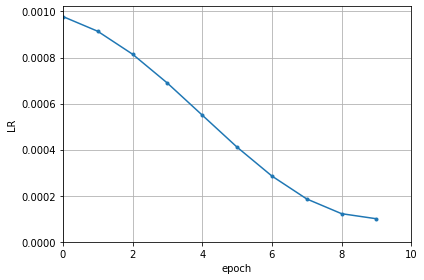

In [24]:
main()

# Demo Testing

In [25]:
# Download weights
# !mkdir -p ./checkpoints/fpn_resnet_18
# !wget D
!mkdir -p ./checkpoints/fpn_resnet_18
# !cp ./checkpoints/fpn_resnet_18/Model_fpn_resnet_18_epoch_2.pth ./checkpoints/fpn_resnet_18
!wget https://github.com/maudzung/SFA3D/raw/master/checkpoints/fpn_resnet_18/fpn_resnet_18_epoch_300.pth -P ./checkpoints/fpn_resnet_18/
!mv ./checkpoints/fpn_resnet_18/Model_fpn_resnet_18_epoch_10.pth ./checkpoints/fpn_resnet_18/fpn_resnet_18_epoch_10.pth 

--2024-12-07 08:59:46--  https://github.com/maudzung/SFA3D/raw/master/checkpoints/fpn_resnet_18/fpn_resnet_18_epoch_300.pth
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maudzung/SFA3D/master/checkpoints/fpn_resnet_18/fpn_resnet_18_epoch_300.pth [following]
--2024-12-07 08:59:46--  https://raw.githubusercontent.com/maudzung/SFA3D/master/checkpoints/fpn_resnet_18/fpn_resnet_18_epoch_300.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50984463 (49M) [application/octet-stream]
Saving to: ‘./checkpoints/fpn_resnet_18/fpn_resnet_18_epoch_300.pth’

fpn_resnet_18_epoch 100%[===================>] 

In [ ]:
import sys
import os
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

import cv2
import torch
import numpy as np


configs = parse_demo_configs()

# Try to download the dataset for demonstration
server_url = 'https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data'
download_url = '{}/{}/{}.zip'.format(server_url, configs.foldername[:-5], configs.foldername)
download_and_unzip(configs.dataset_dir, download_url)

model = create_model(configs)
print('\n\n' + '-*=' * 30 + '\n\n')
assert os.path.isfile(configs.pretrained_path), "No file at {}".format(configs.pretrained_path)
model.load_state_dict(torch.load(configs.pretrained_path, map_location='cpu'))
print('Loaded weights from {}\n'.format(configs.pretrained_path))

configs.device = torch.device('cpu' if configs.no_cuda else 'cuda:{}'.format(configs.gpu_idx))
model = model.to(device=configs.device)
model.eval()

out_cap = None
demo_dataset = Demo_KittiDataset(configs)
with torch.no_grad():
    for sample_idx in range(len(demo_dataset)):
        metadatas, front_bevmap, back_bevmap, img_rgb = demo_dataset.load_bevmap_front_vs_back(sample_idx)
        front_detections, front_bevmap, fps = do_detect(configs, model, front_bevmap, is_front=True)
        back_detections, back_bevmap, _ = do_detect(configs, model, back_bevmap, is_front=False)

        # Draw prediction in the image
        front_bevmap = (front_bevmap.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        front_bevmap = cv2.resize(front_bevmap, (BEV_WIDTH, BEV_HEIGHT))
        front_bevmap = draw_predictions(front_bevmap, front_detections, configs.num_classes)
        # Rotate the front_bevmap
        front_bevmap = cv2.rotate(front_bevmap, cv2.ROTATE_90_COUNTERCLOCKWISE)

        # Draw prediction in the image
        back_bevmap = (back_bevmap.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        back_bevmap = cv2.resize(back_bevmap, (BEV_WIDTH, BEV_HEIGHT))
        back_bevmap = draw_predictions(back_bevmap, back_detections, configs.num_classes)
        # Rotate the back_bevmap
        back_bevmap = cv2.rotate(back_bevmap, cv2.ROTATE_90_CLOCKWISE)

        # merge front and back bevmap
        full_bev = np.concatenate((back_bevmap, front_bevmap), axis=1)

        img_path = metadatas['img_path'][0]
        img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
        calib = Calibration(configs.calib_path)
        kitti_dets = convert_det_to_real_values(front_detections)
        if len(kitti_dets) > 0:
            kitti_dets[:, 1:] = lidar_to_camera_box(kitti_dets[:, 1:], calib.V2C, calib.R0, calib.P2)
            img_bgr = show_rgb_image_with_boxes(img_bgr, kitti_dets, calib)
        img_bgr = cv2.resize(img_bgr, (BEV_WIDTH * 2, 375))

        out_img = np.concatenate((img_bgr, full_bev), axis=0)

        if out_cap is None:
            out_cap_h, out_cap_w = out_img.shape[:2]
            fourcc = cv2.VideoWriter_fourcc(*'MJPG')
            out_path = os.path.join(configs.results_dir, '{}_both_2_sides.avi'.format(configs.foldername))
            print('Create video writer at {}'.format(out_path))
            out_cap = cv2.VideoWriter(out_path, fourcc, 5, (out_cap_w, out_cap_h))

        out_cap.write(out_img)

if out_cap:
    out_cap.release()
    
print("Video Created!")



Unzipping the downloaded data...
using ResNet architecture with feature pyramid


-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*=


Loaded weights from ./checkpoints/fpn_resnet_18/fpn_resnet_18_epoch_300.pth

Create video writer at ./results/fpn_resnet_18/2011_09_26_drive_0014_sync_both_2_sides.avi


In [37]:
from sklearn.metrics import precision_score, recall_score

# Store metrics for each epoch
metrics_history = {'loss': [], 'precision': [], 'recall': []}

for epoch in range(10):
    model.train()
    train_loss = 0.0

    # Training loop
    for batch_data in train_dataloader:
        optimizer.zero_grad()
        images, targets = batch_data['images'], batch_data['targets']

        outputs = model(images)
        loss = loss_function(outputs, targets)  # Replace with the actual loss function
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation loop
    model.eval()
    val_loss = 0.0
    all_true_labels = []
    all_pred_labels = []
    
    with torch.no_grad():
        for batch_data in val_dataloader:
            images, targets = batch_data['images'], batch_data['targets']

            # Forward pass
            outputs = model(images)
            val_loss += loss_function(outputs, targets).item()

            # Match predictions to ground truth
            pred_boxes, pred_labels = extract_predictions(outputs)
            true_boxes, true_labels = extract_ground_truth(targets)

            # Evaluate predictions using IoU
            tp, fp, fn = calculate_tp_fp_fn(pred_boxes, pred_labels, true_boxes, true_labels)
            all_true_labels.extend(true_labels)
            all_pred_labels.extend(pred_labels)

    # Calculate metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    metrics_history['loss'].append(val_loss / len(val_dataloader))
    metrics_history['precision'].append(precision)
    metrics_history['recall'].append(recall)

    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {val_loss:.4f} - Precision: {precision:.2f} - Recall: {recall:.2f}")


NameError: name 'train_dataloader' is not defined